# Question c (Part 1): Can we predict the maximum strength of a storm?
For this question, we decided to only use starting and current known conditions to predict the maximum strength of a storm. Indeed, we are interested in predicting the maximum strenght of an storm at the beginning or in the midst of an storm, not at the end when we have all the fact. Therefore variables that can be determined only after the end of the storm such as Duration, EndLat, MinWind, MaxPressure will be excluded.

We will use only the following variables
- TimeSinceStart
- Lon
- Lat
- Wind
- Pressure 
- Season
- Storm Type
- MaxStrength (Target variable)
- StartLat
- StartLon
- StartWind
- StartPressure
- StartStormType

reframing the question, can we predict the maximum strength of a storm given the starting and current conditions?

# 5) Techniques used to answer the question.

For Question c, the task is  to build a classifier to predict the maximum strenght of a storm. We considered multiples classification estimators suitable with the size and shape of our dataset. Hence, we considered the five following estimators: Logistic Regression, Naive Bayes, K-nearest Neighbors, Decision Tree, and random forest classifiers.


For each of our models, we apply the following pipeline: spliting dataset into trainning and test sets, scaling if neccessary, hyperparameters tuning, model fit, cross validation and test.

Additionally, we use f1_macro as a performance metric to evaluate our model because of the class imbalance in the target variable and the fact that we care about both precison and recall, false positive and false negative globally, and all classes equally. This makes accuracy a misleading performance metric.

# 6) Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 30, 8
rcParams["axes.labelsize"] = 20
sb.set_style('whitegrid')
sb.set(font_scale = 1.5)

# Dataset and Preprocessing

In [3]:
df_start=pd.read_csv('StormDatasetFinal.csv')
df_initial=df_start[['TimeSinceStart','Lat', 'Lon', 'Wind', 'Pressure', 'Season', 'StormType', 'MaxStrength', 'StartLat', 'StartLon',
              'StartWind', 'StartPressure', 'StartStormType']]
df_initial.head()

TimeSinceStart    Lat     Lon  Wind  Pressure  Season     StormType  \
0               0  15.90 -82.000    29      1007  Summer  Tropical Low   
1           10800  15.95 -82.040    29      1006  Summer  Tropical Low   
2           21600  16.00 -82.100    29      1006  Summer  Tropical Low   
3           32400  16.05 -82.193    29      1006  Summer  Tropical Low   
4           43200  16.10 -82.300    29      1006  Summer  Tropical Low   

  MaxStrength  StartLat  StartLon  StartWind  StartPressure StartStormType  
0   Hurricane      15.9     -82.0         29           1007   Tropical Low  
1   Hurricane      15.9     -82.0         29           1007   Tropical Low  
2   Hurricane      15.9     -82.0         29           1007   Tropical Low  
3   Hurricane      15.9     -82.0         29           1007   Tropical Low  
4   Hurricane      15.9     -82.0         29           1007   Tropical Low

In [4]:
df_initial.columns

Index(['TimeSinceStart', 'Lat', 'Lon', 'Wind', 'Pressure', 'Season',
       'StormType', 'MaxStrength', 'StartLat', 'StartLon', 'StartWind',
       'StartPressure', 'StartStormType'],
      dtype='object')

In [5]:
#dopping Null-values rows (23)
df= df_initial.copy()
df = df.dropna()                       
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10425 entries, 0 to 10447
Data columns (total 13 columns):
TimeSinceStart    10425 non-null int64
Lat               10425 non-null float64
Lon               10425 non-null float64
Wind              10425 non-null int64
Pressure          10425 non-null int64
Season            10425 non-null object
StormType         10425 non-null object
MaxStrength       10425 non-null object
StartLat          10425 non-null float64
StartLon          10425 non-null float64
StartWind         10425 non-null int64
StartPressure     10425 non-null int64
StartStormType    10425 non-null object
dtypes: float64(4), int64(5), object(4)
memory usage: 1.1+ MB
None


### Checking the frequency distribution of target variable: MaxStrength
We have a skewed class distributionT. Indeed, the target variable is highly imbalanced with the Hurricane and and Trorpical Storm classes dwarfing the other classes. For convenience, we will refer to Hurricanes and Trorpical Storm classes as the majority classes and the Tropical Depression, Extratropical and Subtropical Storm as the minority classes.

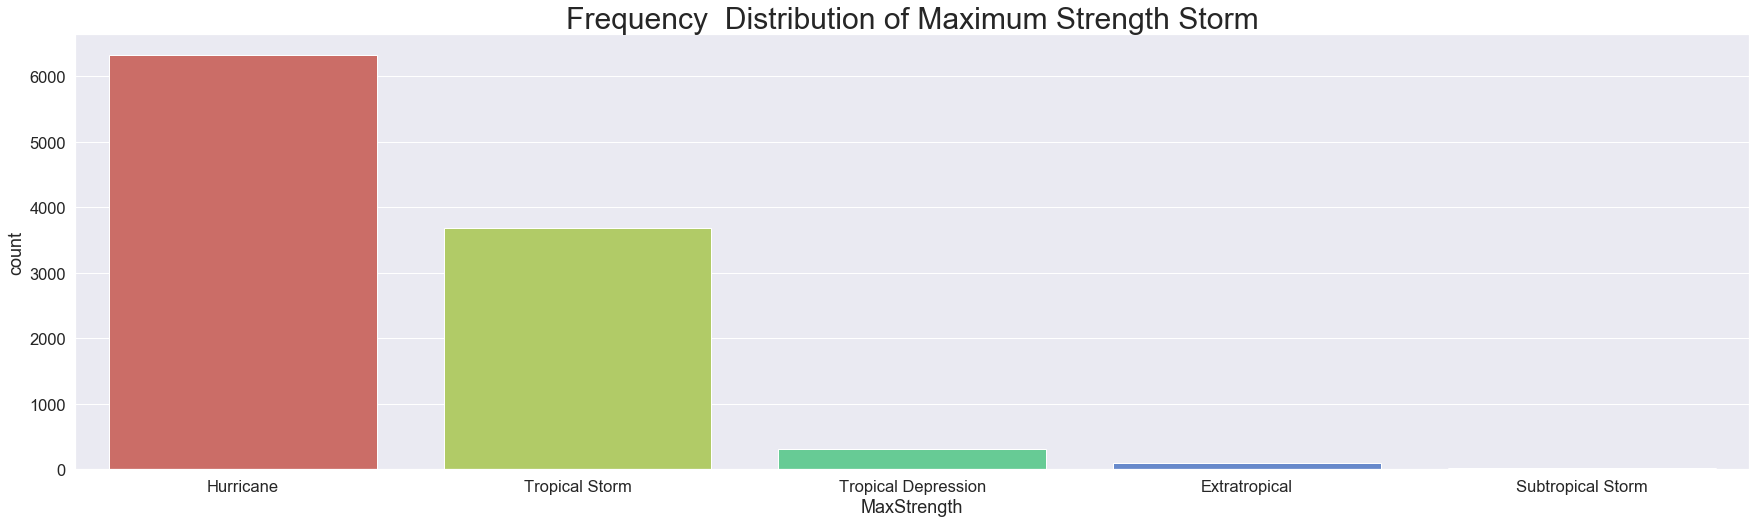

In [6]:
sb.countplot(x='MaxStrength', data=df, palette='hls').set_title("Frequency  Distribution of Maximum Strength Storm", fontsize=30);

Although wind is a critical trait of a storm, it is not the only characteristic that defines the type of a storm. Indeed, except for the hurricane categories, the other storm types have intertwined ranges. The same can be said about pressure.

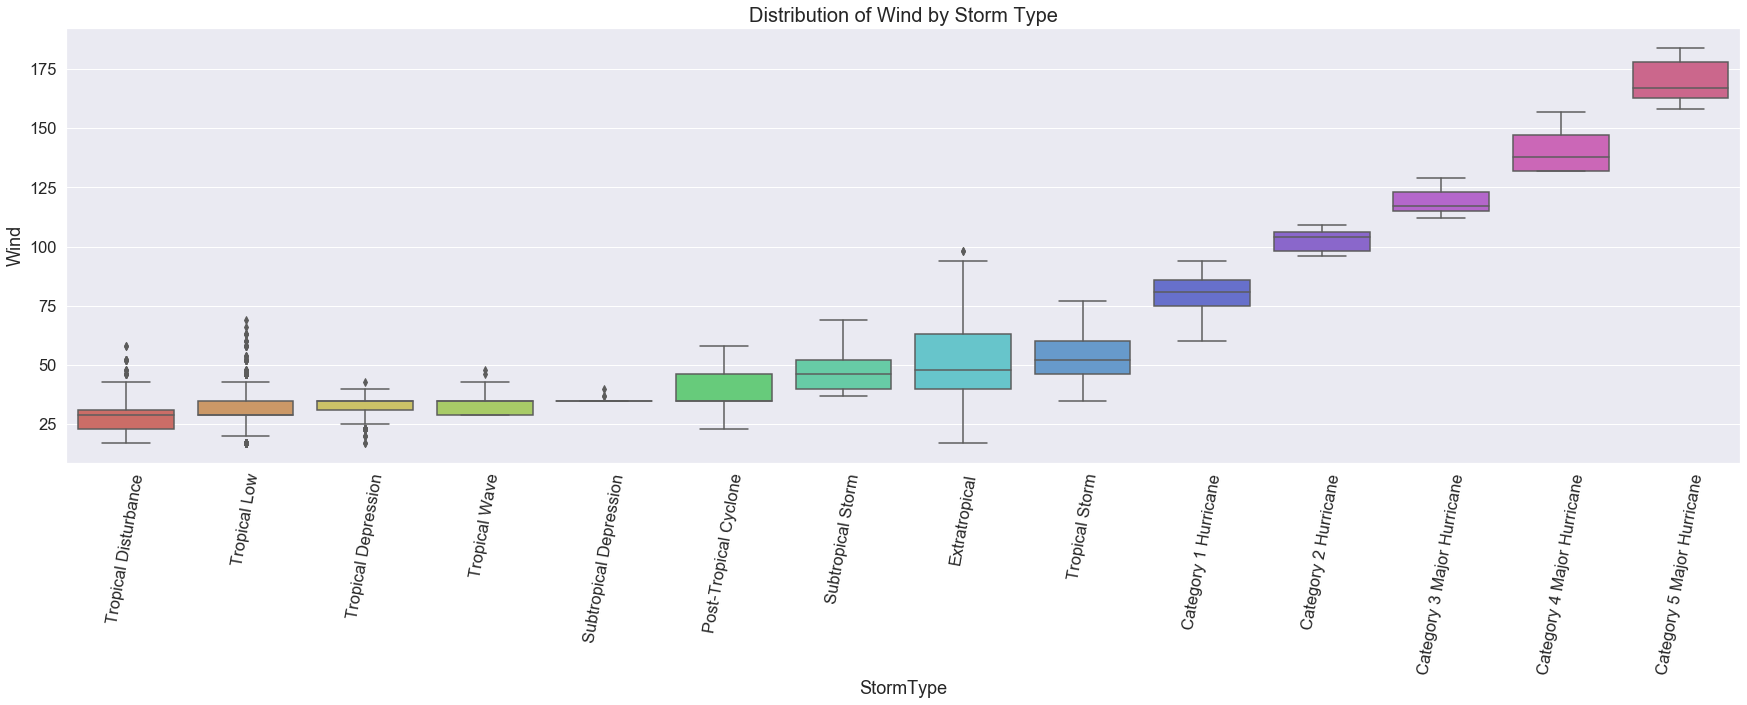

In [7]:
# compute mean per group and find index after sorting
my_orderW = df.groupby(by=['StormType'])['Wind'].mean().sort_values(ascending=False).iloc[::-1].index
chart=sb.boxplot(x='StormType',y='Wind', data=df, order=my_orderW, palette='hls')
chart.set_title("Distribution of Wind by Storm Type", fontsize=20)
chart.set_xticklabels(chart.get_xticklabels(),rotation=80);

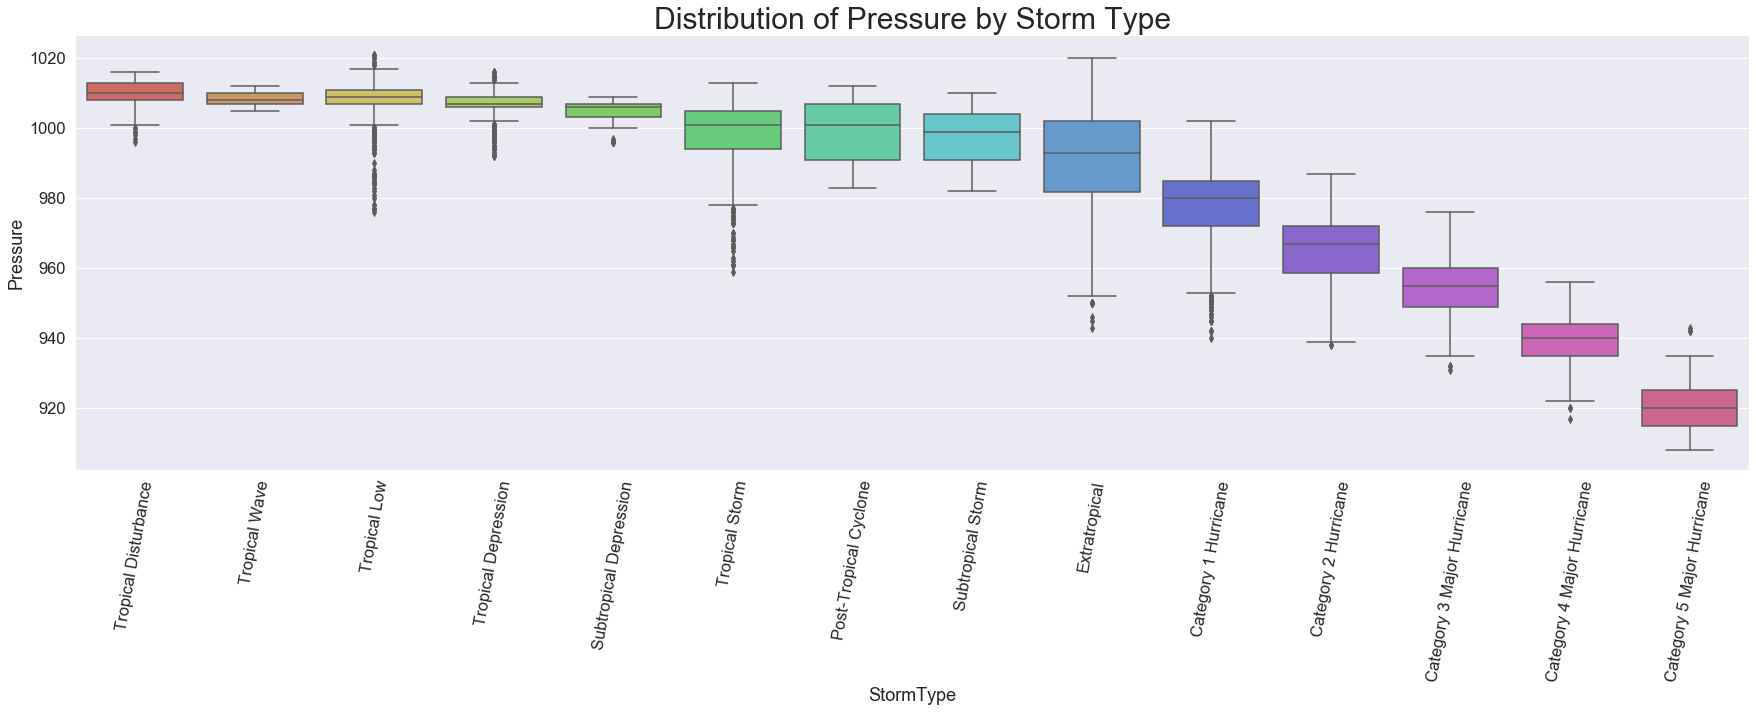

In [8]:
# compute mean per group and find index after sorting
my_orderP = df.groupby(by=['StormType'])['Pressure'].mean().sort_values(ascending=True).iloc[::-1].index
chart=sb.boxplot(x='StormType',y='Pressure', data=df, order=my_orderP, palette='hls')
chart.set_title("Distribution of Pressure by Storm Type", fontsize=30)
chart.set_xticklabels(chart.get_xticklabels(),rotation=80);

Indeed, characteristics that define the type of storm includes:
- Position of center
- Size and shape of eye, if any
- Pressure
- Direction of movement
- Speed of movement
- Wind speed
- Maximum sustained wind
- Storm radius and symmetry
- Storm surge potential for a particular coastal location
- Storm tide potential for a particular coastal location

In terms of strength, the ascending order is as follow: disturbance, depression, storm, hurricane. A tropical wave is an inverted trough (an elongated area of relatively low pressure)  or cyclonic curvature maximum moving east to west across the tropics. A tropical low is a weaker version of a tropical cyclone and develop in low pressure systems. A post-tropical cyclone is a cyclone that no longer possesses sufficient tropical characteristics to be considered a tropical cyclone. Tropical and subtropical storms can be considered as cousins. However, tropical storms have warm core and a symmetrical structure whereas subtropical storms have a cold core with an asymmetrical structure. Moreover subtropical storms are generally less dense and more spread out than tropical storms. Finally, an extratropical storm has a cold core at its central point and is associated with frontal zones. In fact, a subtropical is a hybrid of tropical storm and extratropical storm.
Based on this, we are applying the following ordinal encoding to all the storm related columns:
- Tropical Disturbance: 1
- Tropical Low: 2 
- Tropical Wave: 3 
- Subtropical Depression: 4
- Tropical Depression: 5 
- Post-Tropical Cyclone: 6
- Extratropical: 7
- Subtropical Storm: 8,
- Tropical Storm: 9
- Hurricane: 10
- Category 1 Hurricane: 11 
- Category 2 Hurricane: 12
- Category 3 Major Hurricane: 13
- Category 4 Major Hurricane: 14
- Category 5 Major Hurricane: 15

The season is encoded as follow:
- Autumn: 0
- Spring: 1
- Summer: 2
- Winter: 3

### Encoding categorical variables: season and storm columns using semi-ordinal

In [9]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_encoded = df.copy()
#encoding season
df_encoded['Season'] = label_encoder.fit_transform(df_encoded['Season'])

dic_to_replace = {'Tropical Disturbance': 1, 'Tropical Low': 2, 'Tropical Wave': 3, 'Subtropical Depression': 4, 
                  'Tropical Depression': 5, 'Post-Tropical Cyclone': 6, 'Extratropical': 7, 'Subtropical Storm': 8,
                  'Tropical Storm': 9, 'Hurricane': 10, 'Category 1 Hurricane': 11, 'Category 2 Hurricane': 12, 
                  'Category 3 Major Hurricane': 13, 'Category 4 Major Hurricane': 14, 'Category 5 Major Hurricane': 15}

df_encoded=df_encoded.replace(dic_to_replace)
df_encoded['StormType'] = df_encoded['StormType'].astype(int)
df_encoded['MaxStrength'] = df_encoded['MaxStrength'].astype(int)
df_encoded['StartStormType'] = df_encoded['StartStormType'].astype(int)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10425 entries, 0 to 10447
Data columns (total 13 columns):
TimeSinceStart    10425 non-null int64
Lat               10425 non-null float64
Lon               10425 non-null float64
Wind              10425 non-null int64
Pressure          10425 non-null int64
Season            10425 non-null int32
StormType         10425 non-null int32
MaxStrength       10425 non-null int32
StartLat          10425 non-null float64
StartLon          10425 non-null float64
StartWind         10425 non-null int64
StartPressure     10425 non-null int64
StartStormType    10425 non-null int32
dtypes: float64(4), int32(4), int64(5)
memory usage: 977.3 KB


### Checking for independence between features

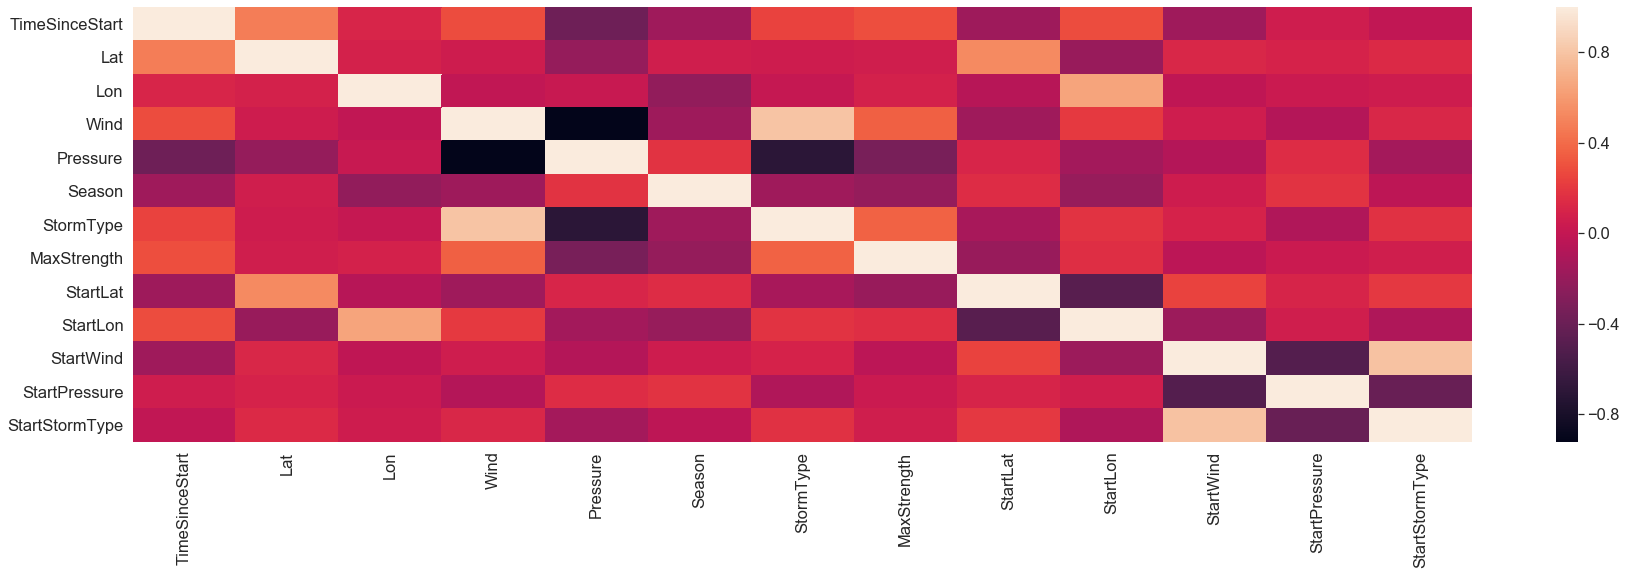

In [10]:
sb.heatmap(df_encoded.corr());

In [11]:
df_encoded.corr()

TimeSinceStart       Lat       Lon      Wind  Pressure  \
TimeSinceStart        1.000000  0.478591  0.110977  0.284172 -0.376382   
Lat                   0.478591  1.000000  0.088549  0.050583 -0.205502   
Lon                   0.110977  0.088549  1.000000 -0.008327  0.017484   
Wind                  0.284172  0.050583 -0.008327  1.000000 -0.923189   
Pressure             -0.376382 -0.205502  0.017484 -0.923189  1.000000   
Season               -0.158072  0.064285 -0.219977 -0.168804  0.174478   
StormType             0.246175  0.046279  0.009355  0.802586 -0.703994   
MaxStrength           0.288434  0.064403  0.085976  0.359679 -0.336658   
StartLat             -0.167381  0.528458 -0.057710 -0.157276  0.107587   
StartLon              0.283082 -0.194424  0.653500  0.210300 -0.145736   
StartWind            -0.157371  0.117892 -0.014669  0.056479 -0.074110   
StartPressure         0.053721  0.097756  0.033467 -0.069927  0.144205   
StartStormType       -0.010963  0.133065  0.048092  0.118337 -0.141424   

                  Season  StormType  MaxStrength  StartLat  StartLon  \
TimeSinceStart -0.158072   0.246175     0.288434 -0.167381  0.283082   
Lat             0.064285   0.046279     0.064403  0.528458 -0.194424   
Lon            -0.219977   0.009355     0.085976 -0.057710  0.653500   
Wind           -0.168804   0.802586     0.359679 -0.157276  0.210300   
Pressure        0.174478  -0.703994    -0.336658  0.107587 -0.145736   
Season          1.000000  -0.161195    -0.206658  0.150780 -0.200805   
StormType      -0.161195   1.000000     0.361719 -0.123760  0.180231   
MaxStrength    -0.206658   0.361719     1.000000 -0.187574  0.151164   
StartLat        0.150780  -0.123760    -0.187574  1.000000 -0.480928   
StartLon       -0.200805   0.180231     0.151164 -0.480928  1.000000   
StartWind       0.049503   0.093745    -0.034398  0.247559 -0.174893   
StartPressure   0.176941  -0.082856     0.034116  0.102944  0.067649   
StartStormType -0.026823   0.170722     0.066586  0.198302 -0.091875   

                StartWind  StartPressure  StartStormType  
TimeSinceStart  -0.157371       0.053721       -0.010963  
Lat              0.117892       0.097756        0.133065  
Lon             -0.014669       0.033467        0.048092  
Wind             0.056479      -0.069927        0.118337  
Pressure        -0.074110       0.144205       -0.141424  
Season           0.049503       0.176941       -0.026823  
StormType        0.093745      -0.082856        0.170722  
MaxStrength     -0.034398       0.034116        0.066586  
StartLat         0.247559       0.102944        0.198302  
StartLon        -0.174893       0.067649       -0.091875  
StartWind        1.000000      -0.501616        0.790361  
StartPressure   -0.501616       1.000000       -0.410588  
StartStormType   0.790361      -0.410588        1.000000

#### dropping:
If two features  have a correlation of .7 or more, we will drop the feature with less variance and/orharder to measure
- Pressure because it highly correlated with wind and has less variance than wind (0.92)
- StormType because it is modeterely correlated with wind (0.79)
- StartStormType because it is correlated to StartWind (0.69)

### Going back to the original dataset and dropping the appropriate columns

In [12]:
#Dropping the column Pressure, StormType and StartStormType
df_final= df_initial.drop(columns=['Pressure', 'StormType', 'StartStormType'])
#encoding season
df_final['Season'] = label_encoder.fit_transform(df_final['Season'])
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10448 entries, 0 to 10447
Data columns (total 10 columns):
TimeSinceStart    10448 non-null int64
Lat               10448 non-null float64
Lon               10448 non-null float64
Wind              10448 non-null int64
Season            10448 non-null int32
MaxStrength       10448 non-null object
StartLat          10448 non-null float64
StartLon          10448 non-null float64
StartWind         10448 non-null int64
StartPressure     10448 non-null int64
dtypes: float64(4), int32(1), int64(4), object(1)
memory usage: 775.5+ KB
None


In [13]:
df_final.head()

TimeSinceStart    Lat     Lon  Wind  Season MaxStrength  StartLat  \
0               0  15.90 -82.000    29       2   Hurricane      15.9   
1           10800  15.95 -82.040    29       2   Hurricane      15.9   
2           21600  16.00 -82.100    29       2   Hurricane      15.9   
3           32400  16.05 -82.193    29       2   Hurricane      15.9   
4           43200  16.10 -82.300    29       2   Hurricane      15.9   

   StartLon  StartWind  StartPressure  
0     -82.0         29           1007  
1     -82.0         29           1007  
2     -82.0         29           1007  
3     -82.0         29           1007  
4     -82.0         29           1007

# Dataset Splitting
We performed a strafied split of the dataset because of the class imbalance of the target varible. The dataset was split as folloow:
- 80% Training set
- 20% Test Set

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_final.drop('MaxStrength', axis=1),
                                                   df_final['MaxStrength'], test_size=0.20,
                                                   random_state=312, stratify= df_final['MaxStrength'])

In [15]:
print(X_train.shape)
print(y_train.shape)

(8358, 9)
(8358,)


### Scaled dataset: training and test sets

In [16]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
norm_X_train = sc.fit_transform(X_train)
norm_X_test = sc.transform(X_test)

# Logistic regression
Although scaling is not required for logistic regression, we will use the scaled dataset to speed up convergence.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

### Hyperparameters Tuning
For this logistic regression model, we want to determine the best set of solver and multi_class to use. We are using a balanced class_weight because the target variable is highly imbalnced.

In [18]:
parameters = {'solver':('newton-cg', 'saga' , 'sag', 'lbfgs'), 'multi_class':('multinomial', 'ovr')}

In [19]:
LogReg=LogisticRegression(class_weight='balanced', max_iter=5000)

We will use stratified folds in all cross validation steps in order to deal with the class imbalance of the target variable.

In [20]:
from sklearn.model_selection import StratifiedKFold
cv_method = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

In [21]:
import warnings
warnings.filterwarnings("ignore")
gs = GridSearchCV(LogReg, parameters, scoring='f1_macro', cv=cv_method, refit=True)
gs.fit(norm_X_train, y_train);

In [22]:
print('The best model is:', gs.best_estimator_)
print('which yielded a mean macro f1_score of', gs.best_score_)

The best model is: LogisticRegression(class_weight='balanced', max_iter=5000, multi_class='ovr',
                   solver='newton-cg')
which yielded a mean macro f1_score of 0.6373129053985609


### Model

In [23]:
RegModel=gs.best_estimator_

The best Logistic regression estimator has the solver and class_class parameters set at newton-cg and one versus rest (ovr).

In [24]:
y_train_pred = RegModel.predict(norm_X_train)

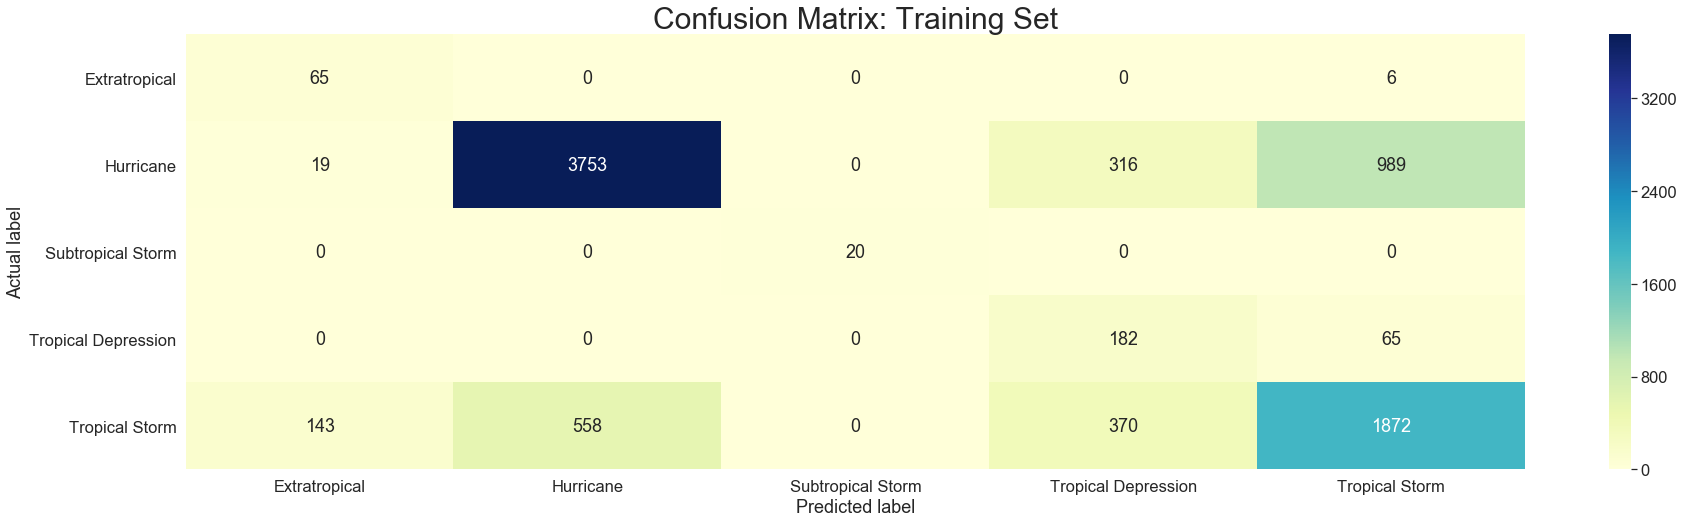

In [25]:
cf_train_matrix = confusion_matrix(y_train, y_train_pred)
class_names=('Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm') # name  of classes
# create heatmap
chart=sb.heatmap(pd.DataFrame(cf_train_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Training Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Training Set

In [26]:
print(classification_report(y_train, y_train_pred))

                     precision    recall  f1-score   support

      Extratropical       0.29      0.92      0.44        71
          Hurricane       0.87      0.74      0.80      5077
  Subtropical Storm       1.00      1.00      1.00        20
Tropical Depression       0.21      0.74      0.33       247
     Tropical Storm       0.64      0.64      0.64      2943

           accuracy                           0.70      8358
          macro avg       0.60      0.81      0.64      8358
       weighted avg       0.76      0.70      0.73      8358



In [27]:
print('The macro f1_score for the training set is', f1_score(y_train, y_train_pred, average='macro'))

The macro f1_score for the training set is 0.639901384432085


### K-fold cross-validation

In [28]:
y_val_pred = cross_val_predict(RegModel, norm_X_train, y_train, cv = cv_method)

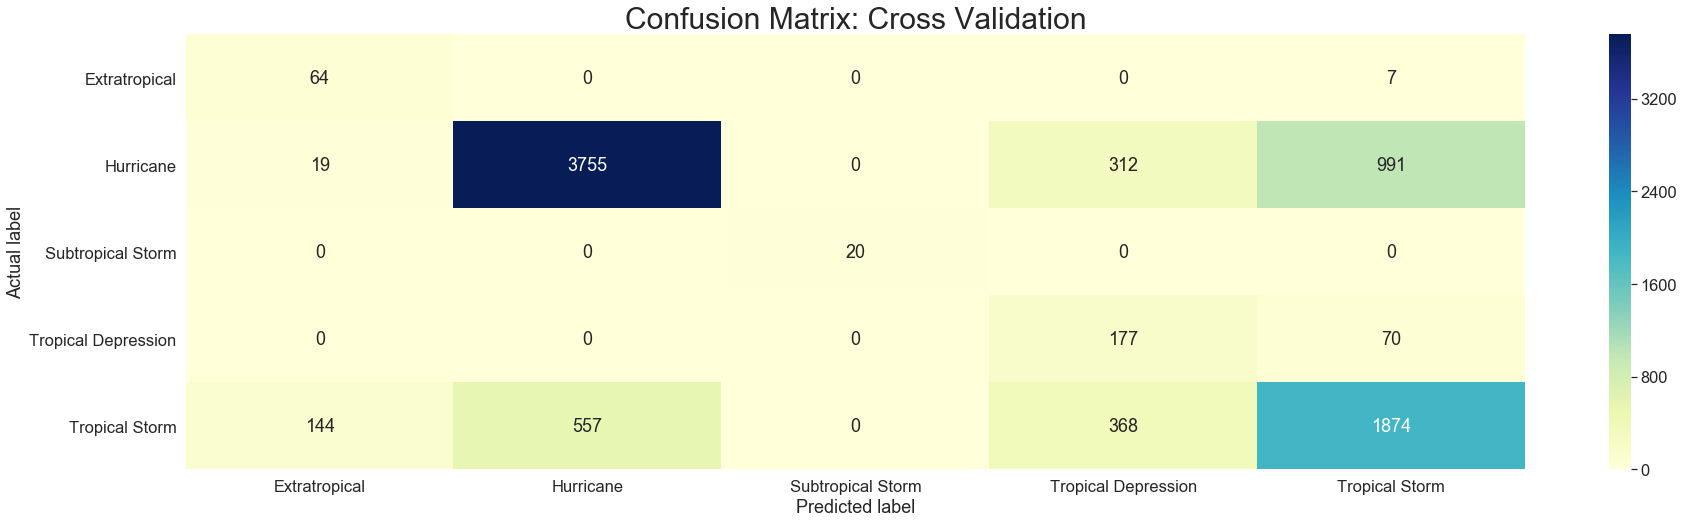

In [29]:
cf_val_matrix = confusion_matrix(y_train, y_val_pred)
chart=sb.heatmap(pd.DataFrame(cf_val_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Cross Validation', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Cross Validation

In [30]:
print(classification_report(y_train, y_val_pred))

                     precision    recall  f1-score   support

      Extratropical       0.28      0.90      0.43        71
          Hurricane       0.87      0.74      0.80      5077
  Subtropical Storm       1.00      1.00      1.00        20
Tropical Depression       0.21      0.72      0.32       247
     Tropical Storm       0.64      0.64      0.64      2943

           accuracy                           0.70      8358
          macro avg       0.60      0.80      0.64      8358
       weighted avg       0.76      0.70      0.73      8358



In [31]:
print('The macro f1_score for cross validation is', f1_score(y_train, y_val_pred, average='macro'))

The macro f1_score for cross validation is 0.6373855946167672


### Deploying and evaluating the model on the test set

#### Classification Report: Cross Validation

In [32]:
y_pred = RegModel.predict(norm_X_test)

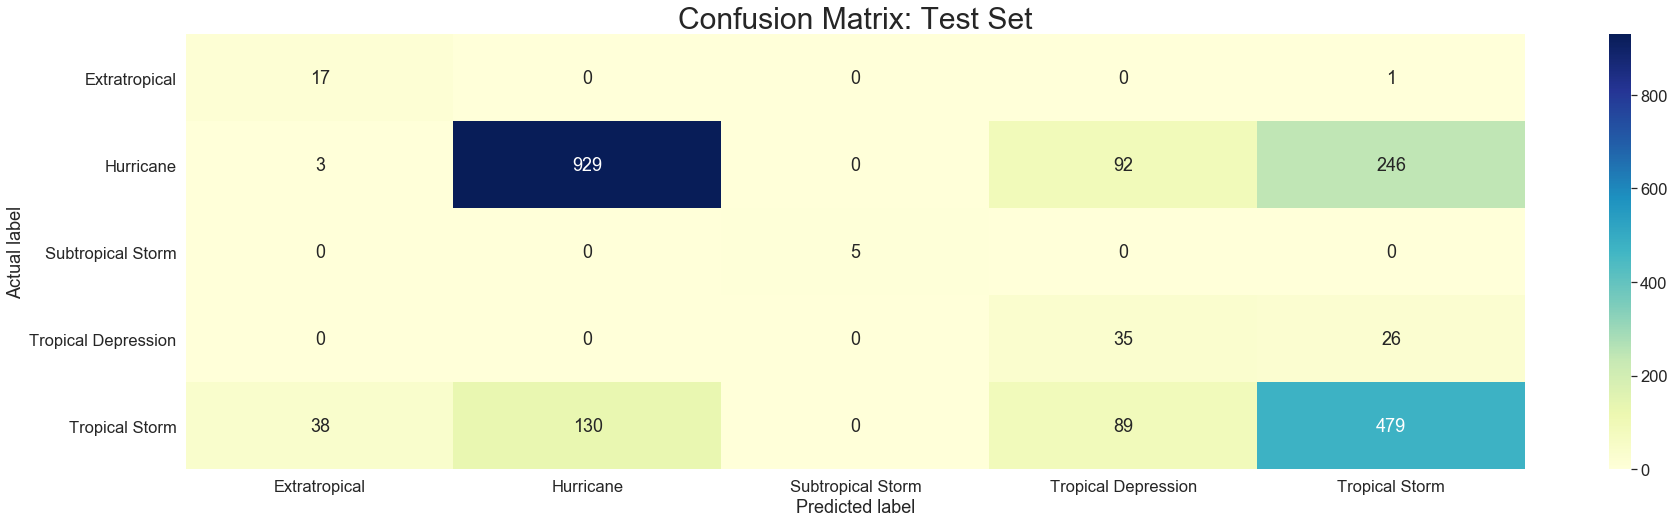

In [33]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
chart=sb.heatmap(pd.DataFrame(cf_test_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Test Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Test Set

In [34]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      Extratropical       0.29      0.94      0.45        18
          Hurricane       0.88      0.73      0.80      1270
  Subtropical Storm       1.00      1.00      1.00         5
Tropical Depression       0.16      0.57      0.25        61
     Tropical Storm       0.64      0.65      0.64       736

           accuracy                           0.70      2090
          macro avg       0.59      0.78      0.63      2090
       weighted avg       0.77      0.70      0.73      2090



In [35]:
print('The macro f1_score for the test set is', f1_score(y_test, y_pred, average='macro'))

The macro f1_score for the test set is 0.6283320977352927


### Discussion of Model 1: Logistic Regression
Although setting the class_weight to balance to reduce bias toward the majority target class (Hurricane), it gave us a precision problem. Indeed, althought the recall of all classes is above average, the precison is very low for the minority classes accross the board. In fact, the model has the tendency to predict:
1. tropical storms as hurricanes and tropical depressions.
1. hurricanes as tropical depressions and tropical storms.
The poor precision scores for the minority classes are mostly due to:
1. Extratropicals: wrongly classified tropical storms as extratropicals
1. Subtropical Storm:  wrongly classified hurricane as subtropicals
1. Troprical Depression: wrongly classified hurricanes and tropical storms as tropical depressions

The model also has a tendency to wrongly classify hurricanes as tropical storms probably because of the numerical imbalance between the two classes. Next, we apply SMOTE, an oversampling method, to the training set to try to remedy with the class imbalance in the target variable and obtain a better model.

## Applying Synthetic Minority Oversampling Technique (SMOTE)

In [36]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(norm_X_train, y_train.ravel())
print(X_train_res.shape)
print(y_train_res.shape)

(25385, 9)
(25385,)


In [37]:
import warnings
warnings.filterwarnings("ignore")
gs_res = GridSearchCV(LogReg, parameters, scoring='f1_macro', cv=10, refit=True)
gs_res.fit(X_train_res, y_train_res)
print('The best model is:', gs_res.best_estimator_)
print('which yielded a mean macro f1_score of', gs_res.best_score_)

The best model is: LogisticRegression(class_weight='balanced', max_iter=5000,
                   multi_class='multinomial', solver='newton-cg')
which yielded a mean macro f1_score of 0.8383841764617459


### Training

In [38]:
RegModelRes=gs_res.best_estimator_

In [39]:
y_train_pred = RegModelRes.predict(X_train_res)

#### Classification Report: Training Set

In [40]:
print(classification_report(y_train_res, y_train_pred))

                     precision    recall  f1-score   support

      Extratropical       0.93      1.00      0.96      5077
          Hurricane       0.80      0.73      0.77      5077
  Subtropical Storm       1.00      1.00      1.00      5077
Tropical Depression       0.79      0.90      0.84      5077
     Tropical Storm       0.67      0.58      0.62      5077

           accuracy                           0.84     25385
          macro avg       0.84      0.84      0.84     25385
       weighted avg       0.84      0.84      0.84     25385



In [41]:
print('The macro f1_score for the training set is', f1_score(y_train_res, y_train_pred, average='macro'))

The macro f1_score for the training set is 0.8389556813846504


### K-fold Cross Validation

In [42]:
y_val_pred = cross_val_predict(RegModelRes, norm_X_train, y_train, cv = cv_method)

#### Classification Report: Cross Validation

In [43]:
print(classification_report(y_train, y_val_pred))

                     precision    recall  f1-score   support

      Extratropical       0.23      1.00      0.38        71
          Hurricane       0.87      0.73      0.80      5077
  Subtropical Storm       0.34      1.00      0.51        20
Tropical Depression       0.21      0.89      0.33       247
     Tropical Storm       0.64      0.58      0.61      2943

           accuracy                           0.69      8358
          macro avg       0.46      0.84      0.52      8358
       weighted avg       0.76      0.69      0.71      8358



In [44]:
print('The macro f1_score for cross validation is', f1_score(y_train, y_val_pred, average='macro'))

The macro f1_score for cross validation is 0.524931966467772


### Deploying and evaluating the model on the test set

In [45]:
y_pred = RegModelRes.predict(norm_X_test)

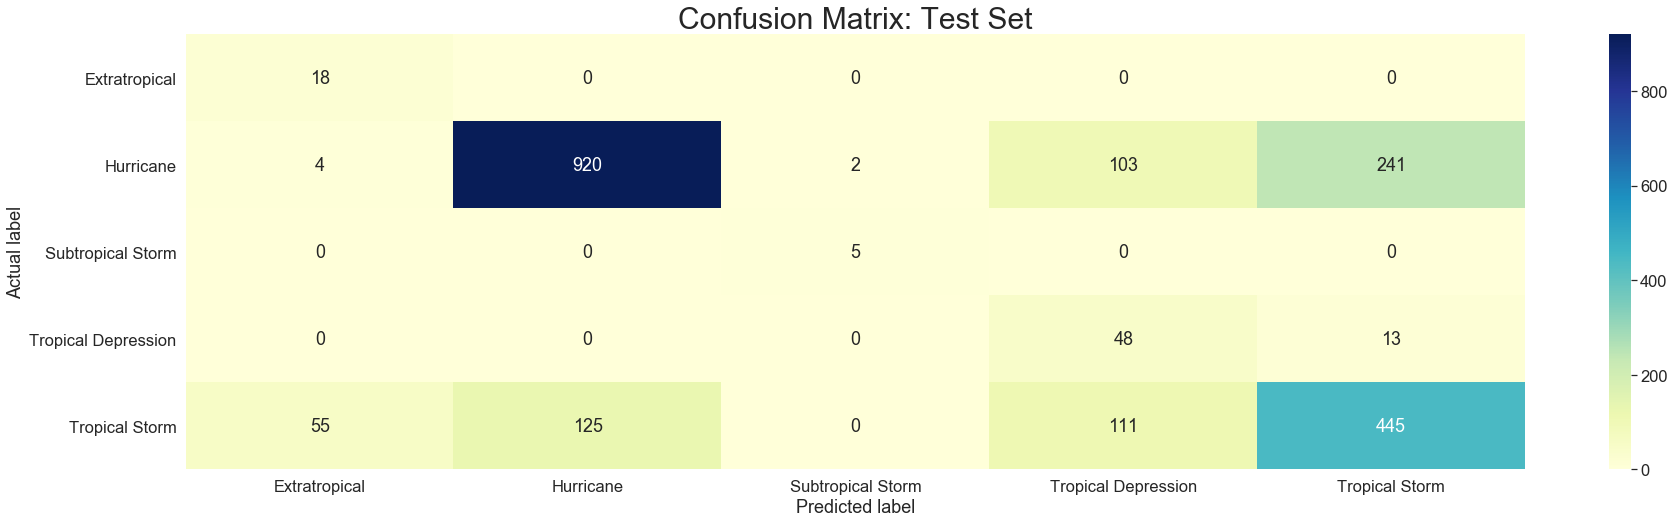

In [46]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
chart=sb.heatmap(pd.DataFrame(cf_test_matrix), annot=True, cmap="YlGnBu", fmt='g')
chart.set_title('Confusion Matrix: Test Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Test Set

In [47]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      Extratropical       0.23      1.00      0.38        18
          Hurricane       0.88      0.72      0.79      1270
  Subtropical Storm       0.71      1.00      0.83         5
Tropical Depression       0.18      0.79      0.30        61
     Tropical Storm       0.64      0.60      0.62       736

           accuracy                           0.69      2090
          macro avg       0.53      0.82      0.58      2090
       weighted avg       0.77      0.69      0.72      2090



In [48]:
print('The macro f1_score for the test set is', f1_score(y_test, y_pred, average='macro'))

The macro f1_score for the test set is 0.5849039595931365


Applying SMOTE did not improve the model at all and introduced an overfitting problem. Indeed, the performance metrics are similar to model's before applying SMOTE.

# Naive Bayes Classifier
Naive Bayes is not a distance based algorithm. Hence we, will use the non scaled dataset.

In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

### Hyperparameters Tuning
For this Naive Bayes model, we want to determine the optimal var_smoothing or portion of the largest variance of all features that is added to variances for calculation stability.

In [50]:
GausNB = GaussianNB()
parameters = {'var_smoothing': np.logspace(0,-9, num=100)}

In [51]:
import warnings
warnings.filterwarnings("ignore")
gnb = GridSearchCV(GausNB, parameters, scoring='f1_macro', cv=cv_method, refit=True)
gnb.fit(X_train, y_train)
print('The best model is:', gnb.best_estimator_)
print('which yielded a mean macro f1_score of', gnb.best_score_)

The best model is: GaussianNB()
which yielded a mean macro f1_score of 0.4779417281679782


We ploted the mean cross validation f1_score as a function of var_smoothing to confirm that the best variance smoothing parameter for this model is 0.

In [52]:
results_NB = pd.DataFrame(gnb.cv_results_['params'])
results_NB['test_score'] = gnb.cv_results_['mean_test_score']

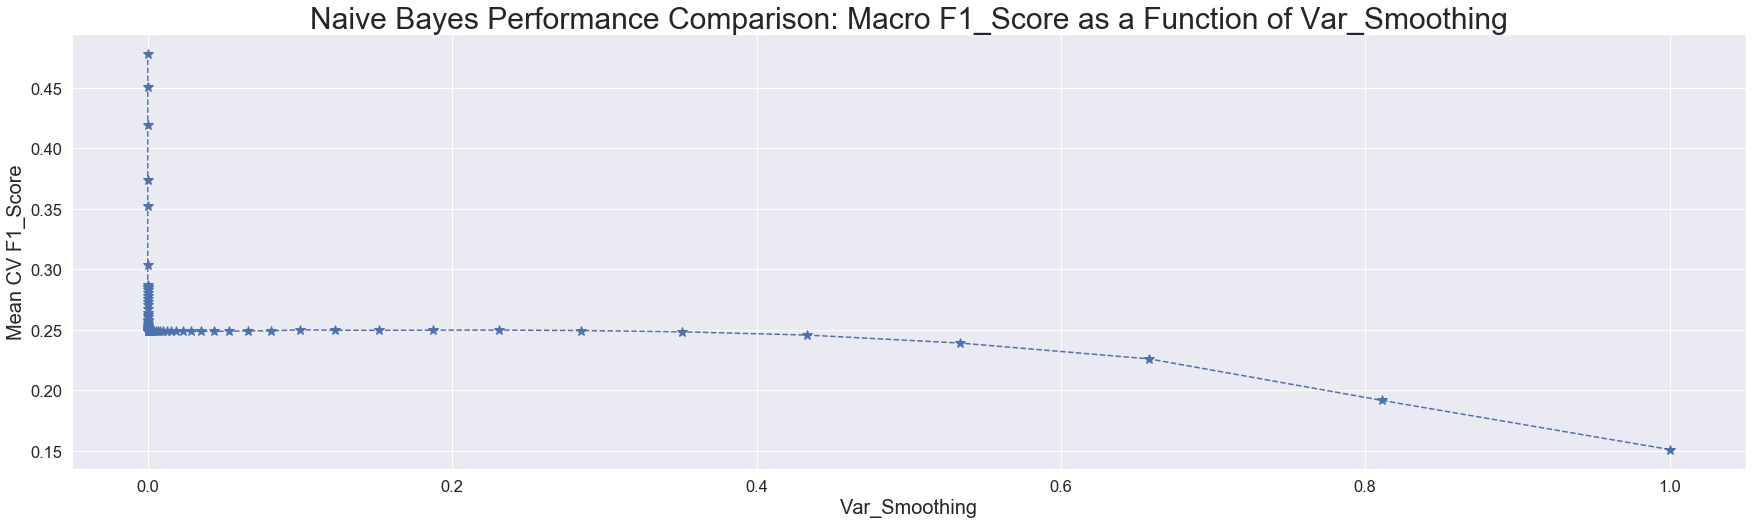

In [53]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '*', linestyle='dashed', markersize=10)    
plt.xlabel('Var_Smoothing', fontsize=20)
plt.ylabel("Mean CV F1_Score", fontsize=20)
plt.title("Naive Bayes Performance Comparison: Macro F1_Score as a Function of Var_Smoothing", fontsize=30)
plt.show()

### Model

In [54]:
NBModel=gnb.best_estimator_
NBModel

GaussianNB()

In [55]:
y_train_pred = NBModel.predict(X_train)

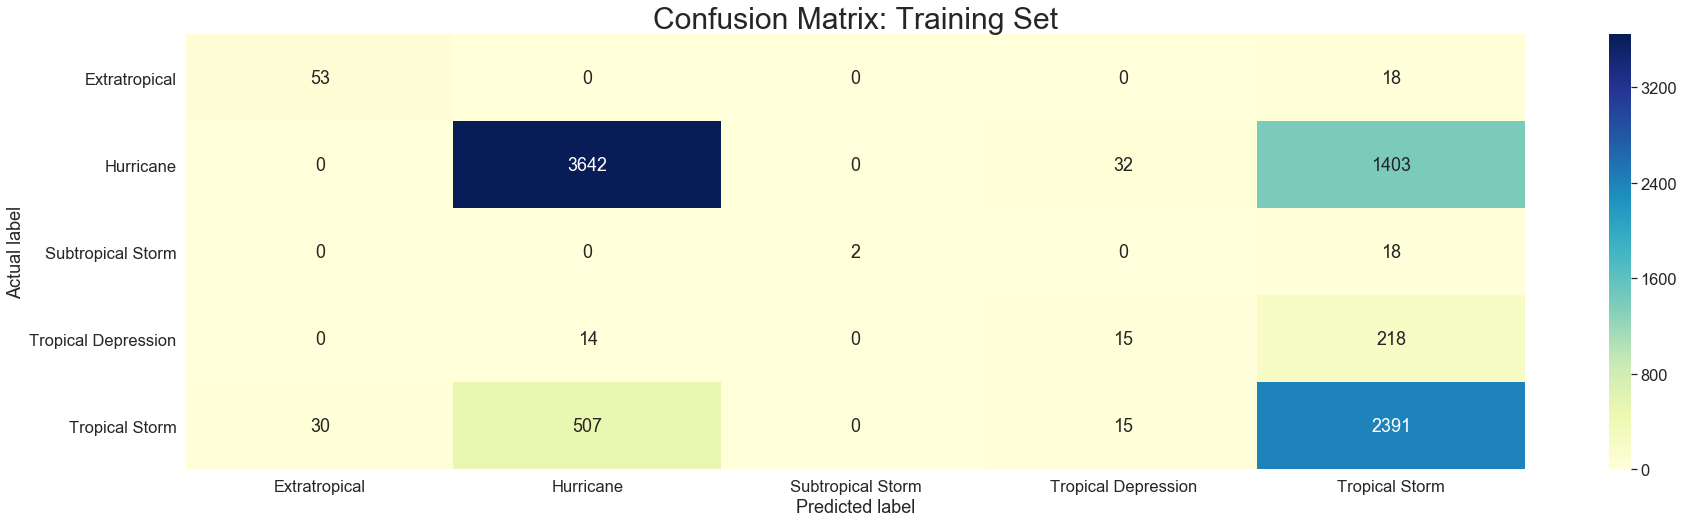

In [56]:
cf_train_matrix = confusion_matrix(y_train, y_train_pred)
class_names=('Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm') # name  of classes
# create heatmap
chart=sb.heatmap(pd.DataFrame(cf_train_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Training Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Training Set

In [57]:
print(classification_report(y_train, y_train_pred))

                     precision    recall  f1-score   support

      Extratropical       0.64      0.75      0.69        71
          Hurricane       0.87      0.72      0.79      5077
  Subtropical Storm       1.00      0.10      0.18        20
Tropical Depression       0.24      0.06      0.10       247
     Tropical Storm       0.59      0.81      0.68      2943

           accuracy                           0.73      8358
          macro avg       0.67      0.49      0.49      8358
       weighted avg       0.75      0.73      0.73      8358



In [58]:
print('The macro f1_score for the training set is', f1_score(y_train, y_train_pred, average='macro'))

The macro f1_score for the training set is 0.48791025029731383


### K-fold cross-validation

In [59]:
y_val_pred = cross_val_predict(NBModel, X_train, y_train, cv = cv_method)

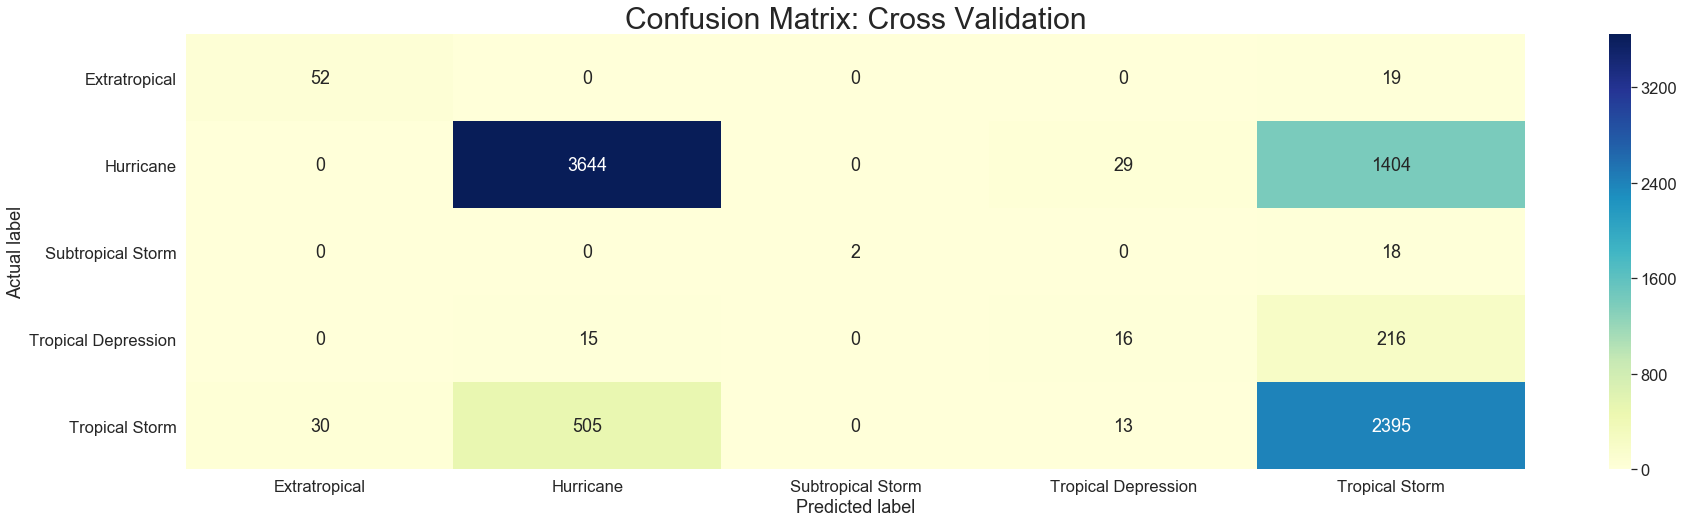

In [60]:
cf_val_matrix = confusion_matrix(y_train, y_val_pred)
chart=sb.heatmap(pd.DataFrame(cf_val_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Cross Validation', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Cross Validation

In [61]:
print(classification_report(y_train, y_val_pred))

                     precision    recall  f1-score   support

      Extratropical       0.63      0.73      0.68        71
          Hurricane       0.88      0.72      0.79      5077
  Subtropical Storm       1.00      0.10      0.18        20
Tropical Depression       0.28      0.06      0.10       247
     Tropical Storm       0.59      0.81      0.68      2943

           accuracy                           0.73      8358
          macro avg       0.68      0.49      0.49      8358
       weighted avg       0.76      0.73      0.73      8358



### Deploying and evaluating the model on the test set

In [62]:
y_pred = NBModel.predict(X_test)

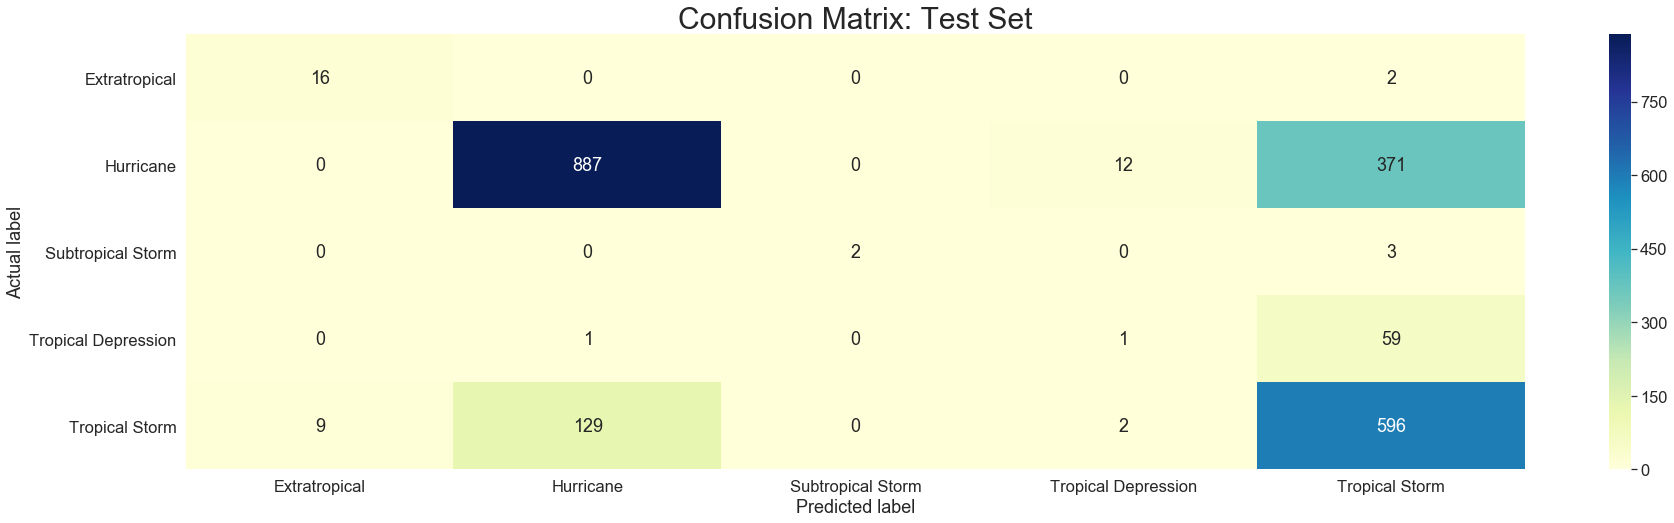

In [63]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
chart=sb.heatmap(pd.DataFrame(cf_test_matrix), annot=True, cmap="YlGnBu", fmt='g')
chart.set_title('Confusion Matrix: Test Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Test Set

In [64]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      Extratropical       0.64      0.89      0.74        18
          Hurricane       0.87      0.70      0.78      1270
  Subtropical Storm       1.00      0.40      0.57         5
Tropical Depression       0.07      0.02      0.03        61
     Tropical Storm       0.58      0.81      0.67       736

           accuracy                           0.72      2090
          macro avg       0.63      0.56      0.56      2090
       weighted avg       0.74      0.72      0.72      2090



### Discussion of Model 2: Naive Bayes

Similar to the logistic regression classifier, The Naive Bayes model has issues too. Indeed, it struggles with the minority classes, especially tropical depression. However, unlike the logistic regression classifier, Naive Bayes has both a precison and recall problem depending on the classes. Like the regression model, this classifier also tends to predict:
1. tropical storms as hurricanes and tropical depressions.
1. hurricanes as tropical depressions and tropical storms.
The poor precision scores for the minority classes are mostly due to:
1. Extratropicals: wrongly classified tropical storms as extratropicals
1. Subtropical Storm:  wrongly classified hurricane as subtropicals
1. Troprical Depression: wrongly classified hurricanes and tropical storms as tropical depressions

The model also has a tendency to wrongly classify hurricanes as tropical storms probably because of the numerical imbalance between the two classes.

Both the Naive Bayes and Logistic Regression models have have an overall poor to average training, cross validation and testing performance metrics. It is either they are are poor estimators for this dataset or we have an underfitting problem despite tuning the hyperparameters.

# k-Nearest Neighbor
KNN is a distance based algorithm. Hence, we will use the scaled dataset here.

In [65]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

### Hyperparameter Tuning: Finding the optimal K and distance metric (power parameter for the Minkowski metric)

In [66]:
KNN = KNeighborsClassifier()
parameters= {'n_neighbors': [1, 3, 5, 7, 9], 'p': [1, 2, 5]} #only odd K; p: 1 (Manhattan), 2 (Euclidean), and 5 (Minkowski)

gknn = GridSearchCV(KNN, parameters, cv=cv_method, scoring='f1_macro', refit=True)

In [67]:
gknn.fit(norm_X_train, y_train)
print('The best model is:', gknn.best_estimator_)
print('which yielded a mean macro f1_score of', gknn.best_score_)

The best model is: KNeighborsClassifier(n_neighbors=1, p=1)
which yielded a mean macro f1_score of 1.0


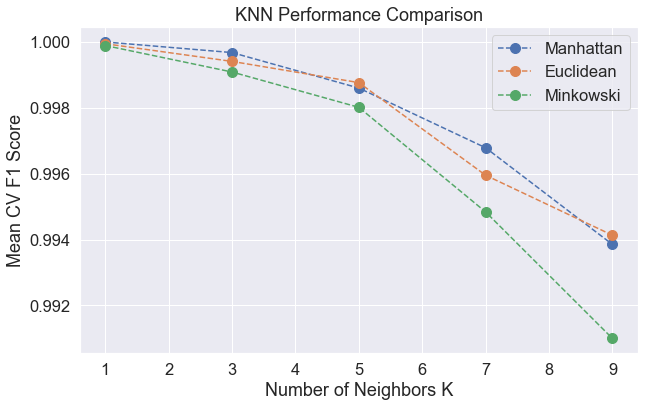

In [68]:
results_KNN = pd.DataFrame(gknn.cv_results_['params'])
results_KNN['test_score'] = gknn.cv_results_['mean_test_score']
results_KNN['metric'] = results_KNN['p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])

plt.figure(figsize=(10,6))
for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = results_KNN[results_KNN['metric'] == i]
    plt.plot(temp['n_neighbors'], temp['test_score'], linestyle='dashed', marker='o', markersize=10, label = i)
    
plt.legend()
plt.xlabel('Number of Neighbors K')
plt.ylabel("Mean CV F1 Score")
plt.title("KNN Performance Comparison")
plt.show()

### Model

In [69]:
KNNModel=gknn.best_estimator_

### K-fold cross-validation

In [70]:
y_val_pred = cross_val_predict(KNNModel, norm_X_train, y_train, cv = cv_method)

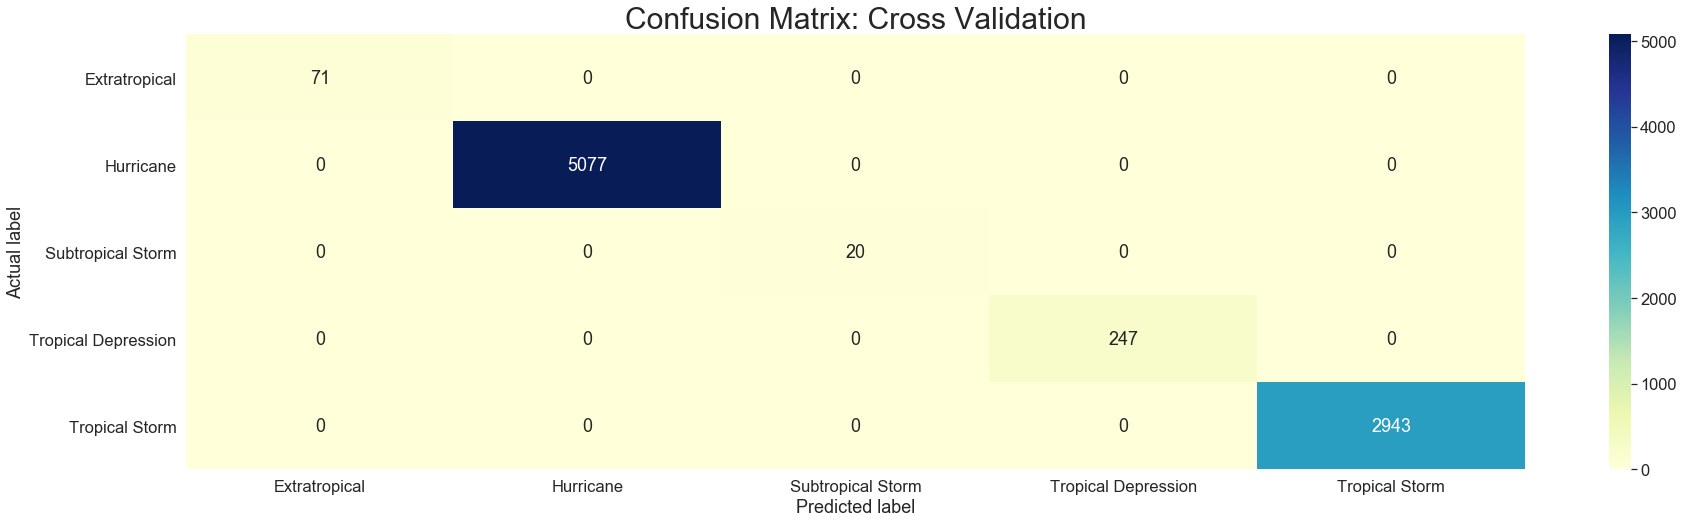

In [71]:
cf_val_matrix = confusion_matrix(y_train, y_val_pred)
chart=sb.heatmap(pd.DataFrame(cf_val_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Cross Validation', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Cross Validation

In [72]:
print(classification_report(y_train, y_val_pred))

                     precision    recall  f1-score   support

      Extratropical       1.00      1.00      1.00        71
          Hurricane       1.00      1.00      1.00      5077
  Subtropical Storm       1.00      1.00      1.00        20
Tropical Depression       1.00      1.00      1.00       247
     Tropical Storm       1.00      1.00      1.00      2943

           accuracy                           1.00      8358
          macro avg       1.00      1.00      1.00      8358
       weighted avg       1.00      1.00      1.00      8358



### Deploying and evaluating the model on the test set

In [73]:
y_pred = KNNModel.predict(norm_X_test)

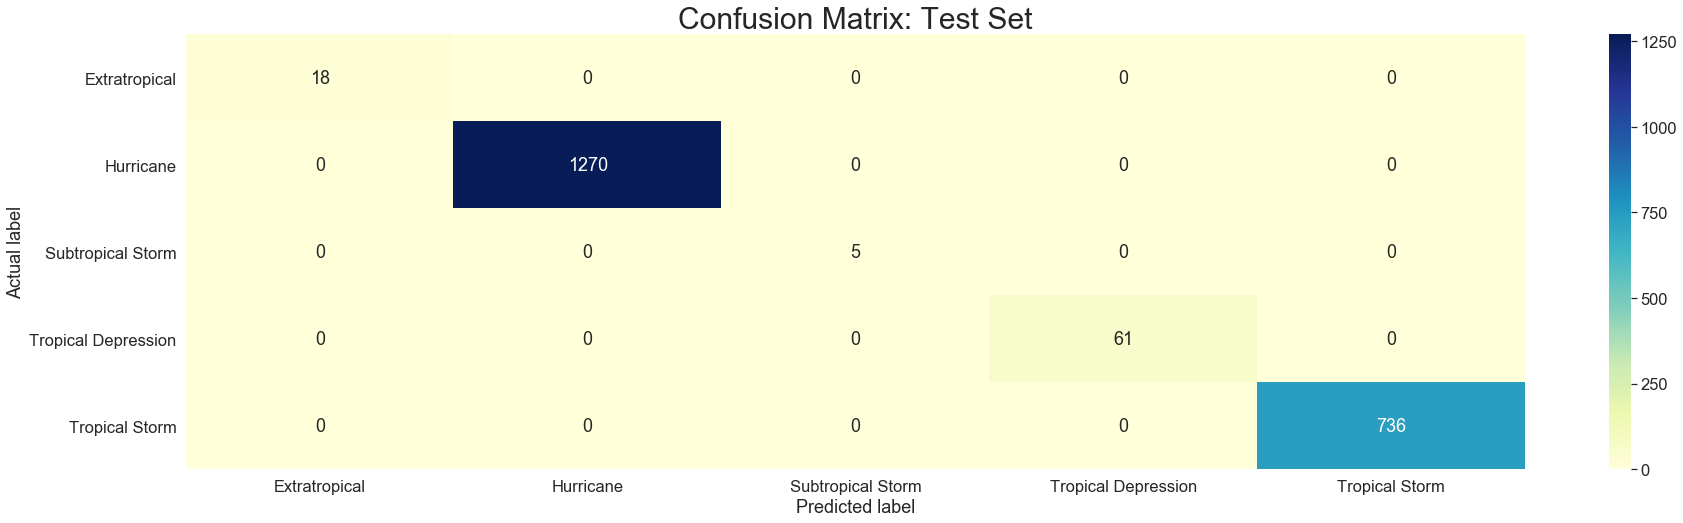

In [74]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
chart=sb.heatmap(pd.DataFrame(cf_test_matrix), annot=True, cmap="YlGnBu", fmt='g')
chart.set_title('Confusion Matrix: Test Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Test Set

In [75]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      Extratropical       1.00      1.00      1.00        18
          Hurricane       1.00      1.00      1.00      1270
  Subtropical Storm       1.00      1.00      1.00         5
Tropical Depression       1.00      1.00      1.00        61
     Tropical Storm       1.00      1.00      1.00       736

           accuracy                           1.00      2090
          macro avg       1.00      1.00      1.00      2090
       weighted avg       1.00      1.00      1.00      2090



### Discussion of Model 3: K-Nearest Neighbors
K-Nearest Neighbors seems to be the perfect estimator. Indeed, the training, cross validation, and testing performance metrics for this model are similar and optimal. However, the model is optimal at K=1. This indicates that the classes probably do not have a linear separation. 

Although KNN is great estimator in this case, It does not offer much insight on how got this near perfect model. Therefore, we will use decision tree to try to gain that insight and better understand our dataset and task.

# Decision Tree
Decision Tree is not a distance based algorithm. Hence we, will use the non-scaled dataset.

### Hyperparameter Tuning

In [76]:
from sklearn import tree
from IPython.display import Image
import pydotplus

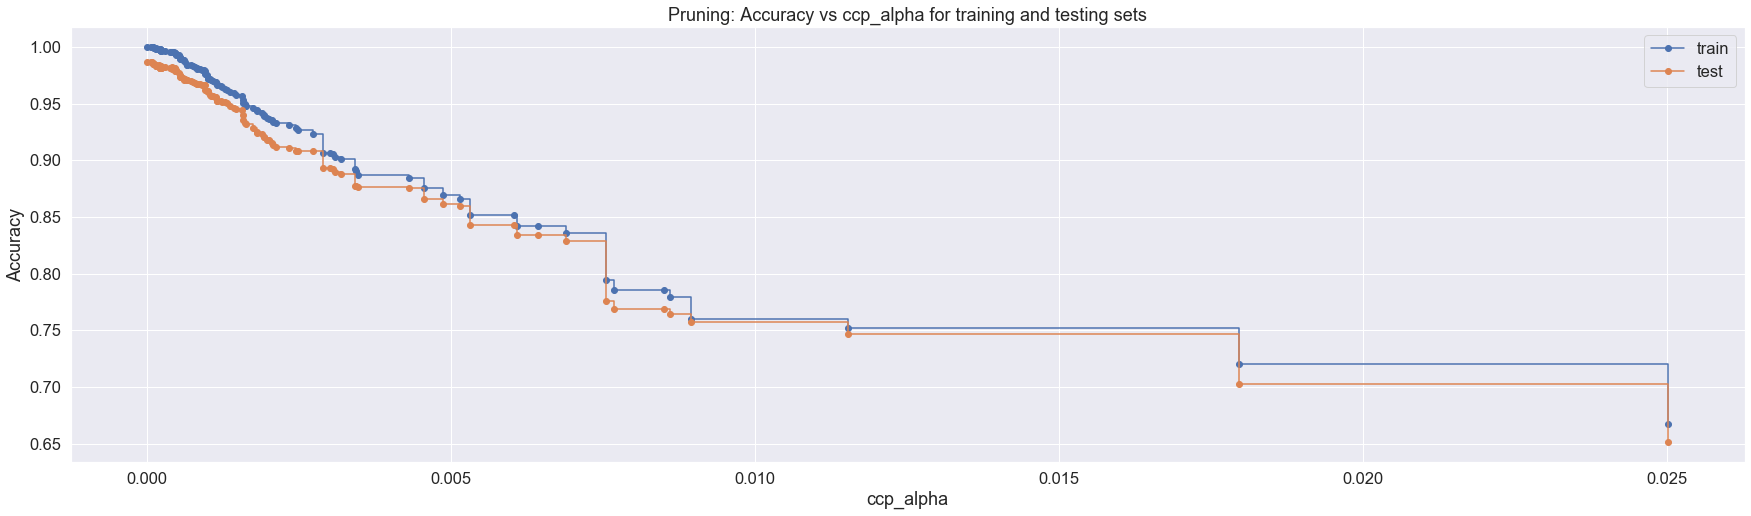

In [77]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Pruning: Accuracy vs ccp_alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()


In order to avoid overfitting and create a decision tree that generalizes better, we want to determine the optimal ccp_alpha (Minimal Cost-Complexity Pruning. With the other parameters kept at their default values, the ccp_alpha  was varied. As seen above, the test accuracy is highest at ccp_alpha=0, which is also the value at which trainning accuracy is the highest. In fact, we obtain the perfect model with the default parameters.

Hence, we will use other parameters such as max_depth and min_impurity_decrease and min_samples_leaf to prune our decision tree.

In [78]:
DT = tree.DecisionTreeClassifier()
parameters= {'criterion': ('gini','entropy'), 'max_depth': [5,6,7,8,9,10],
            'min_samples_split': [5,10,20,30,40], 'min_samples_leaf': [10,20,30], 'class_weight': ('balanced',None), 
             'min_impurity_decrease':[0.05,0.01,0.005,0.001]}


gdt = GridSearchCV(DT, parameters, cv=cv_method, scoring='f1_macro', refit=True)

In [79]:
gdt.fit(X_train, y_train)
print('The best model is:', gdt.best_estimator_)
print('which yielded a mean macro f1_score of', gdt.best_score_)

The best model is: DecisionTreeClassifier(criterion='entropy', max_depth=10,
                       min_impurity_decrease=0.001, min_samples_leaf=10,
                       min_samples_split=5)
which yielded a mean macro f1_score of 0.8866279923782059


### Model

In [80]:
DTModel=gdt.best_estimator_

In [81]:
y_train_pred = DTModel.predict(X_train)

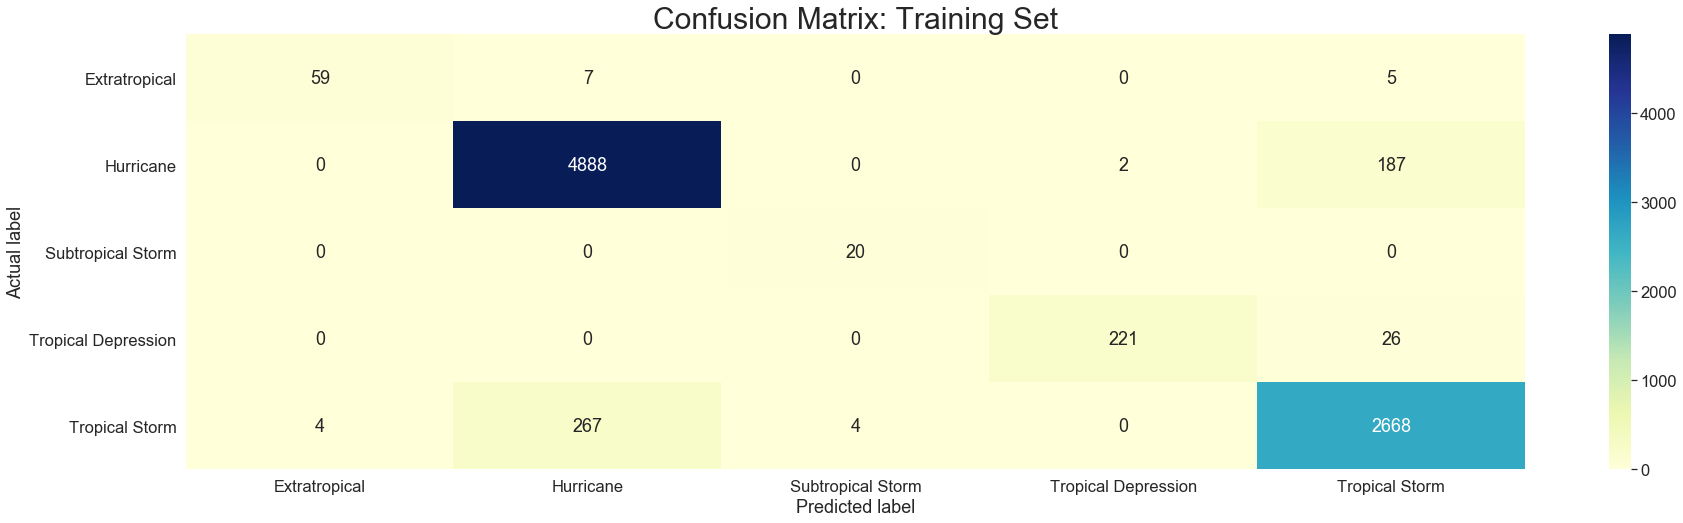

In [82]:
cf_train_matrix = confusion_matrix(y_train, y_train_pred)
class_names=('Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm') # name  of classes
# create heatmap
chart=sb.heatmap(pd.DataFrame(cf_train_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Training Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Training Set

In [83]:
print(classification_report(y_train, y_train_pred))

                     precision    recall  f1-score   support

      Extratropical       0.94      0.83      0.88        71
          Hurricane       0.95      0.96      0.95      5077
  Subtropical Storm       0.83      1.00      0.91        20
Tropical Depression       0.99      0.89      0.94       247
     Tropical Storm       0.92      0.91      0.92      2943

           accuracy                           0.94      8358
          macro avg       0.93      0.92      0.92      8358
       weighted avg       0.94      0.94      0.94      8358



#### Decision Tree Visualization

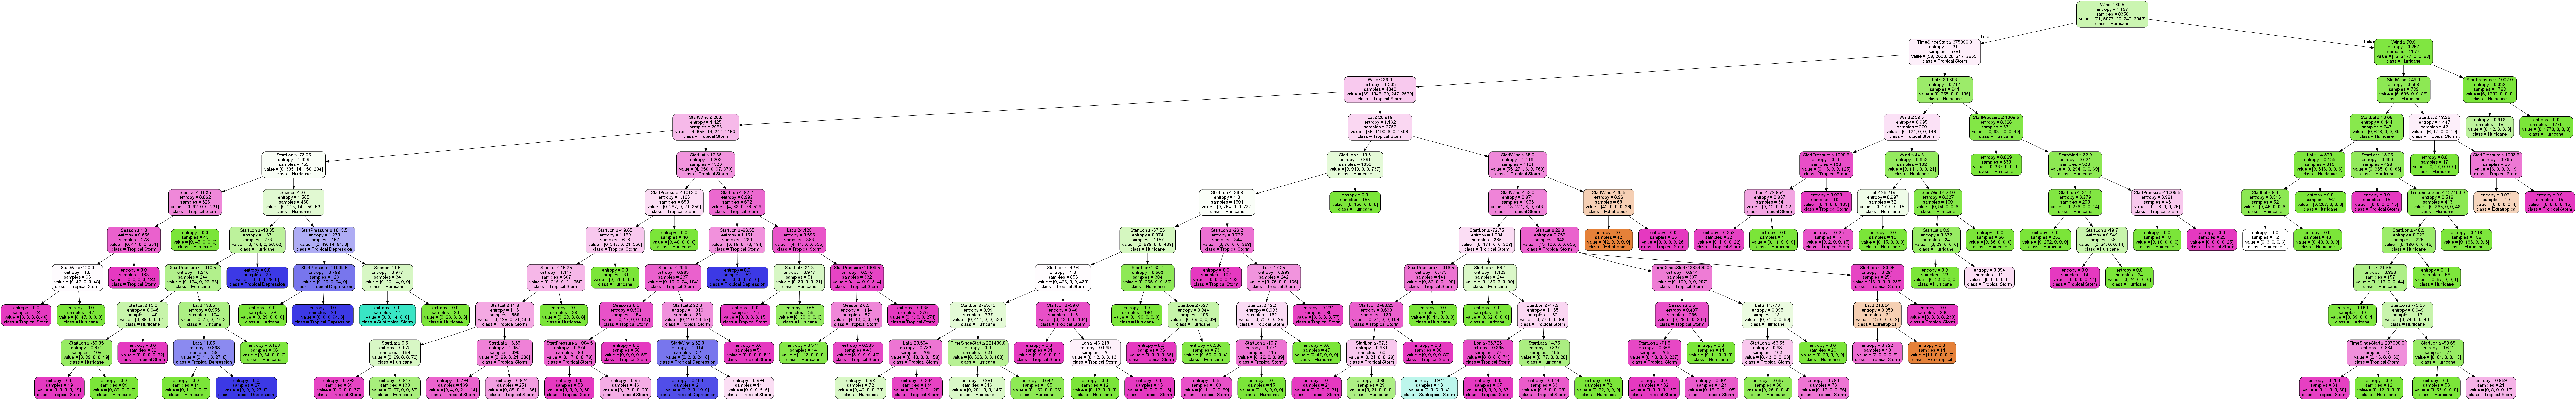

In [84]:
metrics_names=['Lat', 'Lon', 'Wind', 'Season', 'TimeSinceStart', 'StartLat', 'StartLon', 'StartWind', 'StartPressure']
target_names=['MaxStrength']
dot_data = tree.export_graphviz(DTModel, out_file=None, feature_names=X_train.columns, class_names=DTModel.classes_,
                                filled=True, rounded=True,  special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

### Cross Validation

In [85]:
y_val_pred = cross_val_predict(DTModel, X_train, y_train, cv = cv_method)

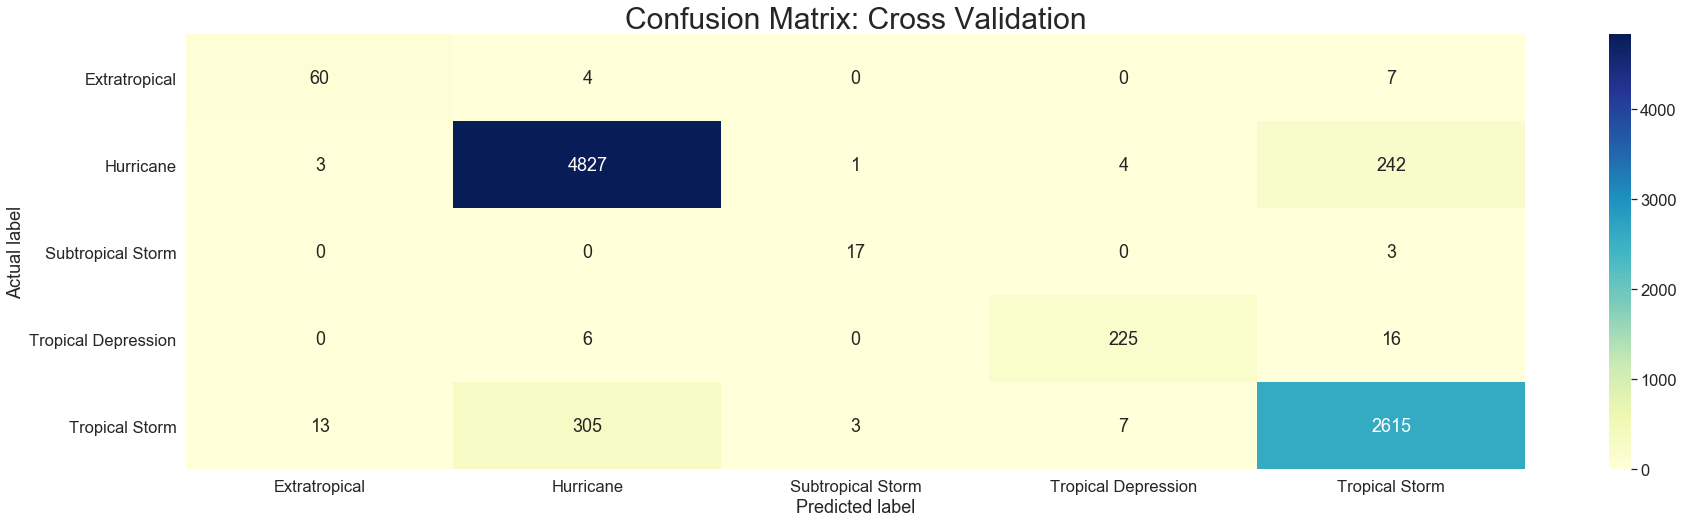

In [86]:
cf_val_matrix = confusion_matrix(y_train, y_val_pred)
chart=sb.heatmap(pd.DataFrame(cf_val_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Cross Validation', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Cross Validation

In [87]:
print(classification_report(y_train, y_val_pred))

                     precision    recall  f1-score   support

      Extratropical       0.79      0.85      0.82        71
          Hurricane       0.94      0.95      0.94      5077
  Subtropical Storm       0.81      0.85      0.83        20
Tropical Depression       0.95      0.91      0.93       247
     Tropical Storm       0.91      0.89      0.90      2943

           accuracy                           0.93      8358
          macro avg       0.88      0.89      0.88      8358
       weighted avg       0.93      0.93      0.93      8358



### Deploying and evaluating the model on the test set

In [88]:
y_pred = DTModel.predict(X_test)

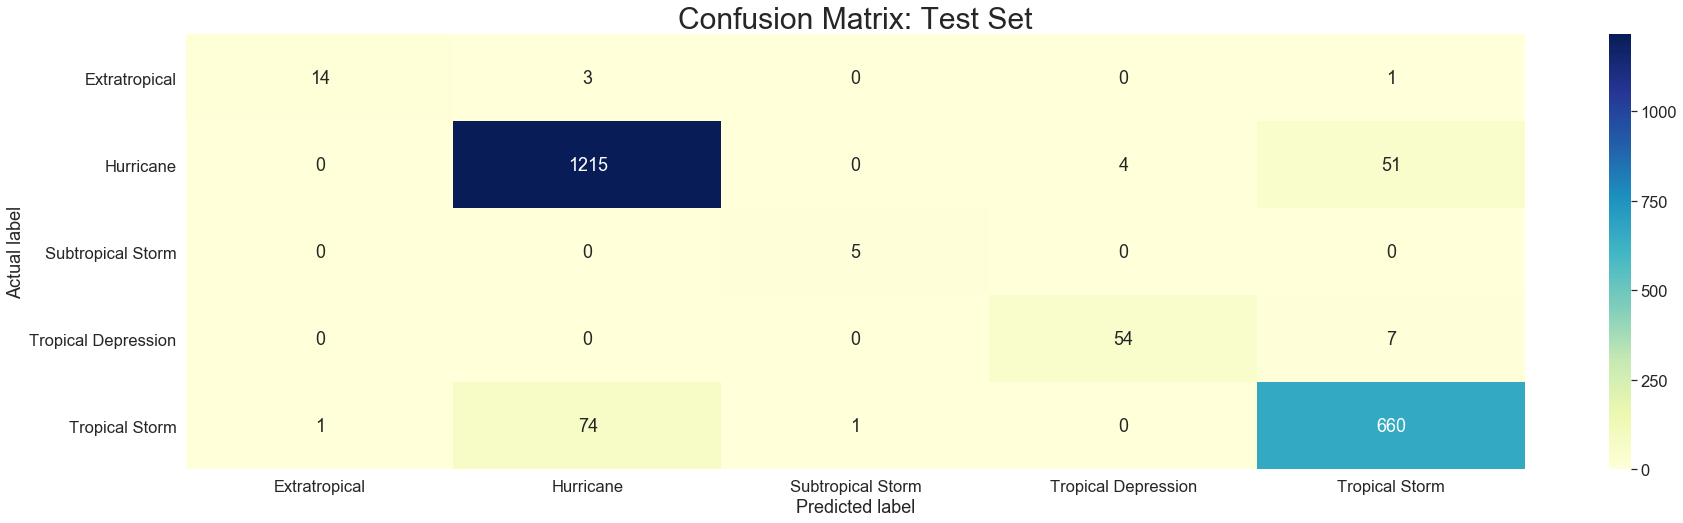

In [89]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
chart=sb.heatmap(pd.DataFrame(cf_test_matrix), annot=True, cmap="YlGnBu", fmt='g')
chart.set_title('Confusion Matrix: Test Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Test Set

In [90]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      Extratropical       0.93      0.78      0.85        18
          Hurricane       0.94      0.96      0.95      1270
  Subtropical Storm       0.83      1.00      0.91         5
Tropical Depression       0.93      0.89      0.91        61
     Tropical Storm       0.92      0.90      0.91       736

           accuracy                           0.93      2090
          macro avg       0.91      0.90      0.90      2090
       weighted avg       0.93      0.93      0.93      2090



### Discussion of Model 4: Decision Tree
Similar to K-Nearest Neighbors, decison tree seems to be a  near perfect estimator as well. Indeed, the training, cross validation, and testing performance metrics for this model are similar and near optimality despite the early pruning.

However, it worth noting a missclassification of hurrican and tropical storm and vice versa is still a problem for this model as well. Since decison tree seems to be a great extimator for this task, we will take a look at random forest classifier as well.

# Random Forest Classifier
Random Forest is not a distance based algorithm. Hence, we will use the non-scaled dataset. We will also use the same hyperparameters used for the decision tree model for comparison.

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
RD = RandomForestClassifier(criterion='entropy', max_depth=10, min_impurity_decrease=0.001, min_samples_leaf=10,
                                 min_samples_split=10)
parameters= {'n_estimators': [50,100,150,200], 'bootstrap': [True, False]}


grd = GridSearchCV(RD, parameters, cv=cv_method, scoring='f1_macro', refit=True)

In [93]:
grd.fit(X_train, y_train)
print('The best model is:', grd.best_estimator_)
print('which yielded a mean macro f1_score of', grd.best_score_)

The best model is: RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_impurity_decrease=0.001, min_samples_leaf=10,
                       min_samples_split=10, n_estimators=150)
which yielded a mean macro f1_score of 0.9854962329713391


### Model

In [94]:
RDModel=grd.best_estimator_

In [95]:
y_train_pred = RDModel.predict(X_train)

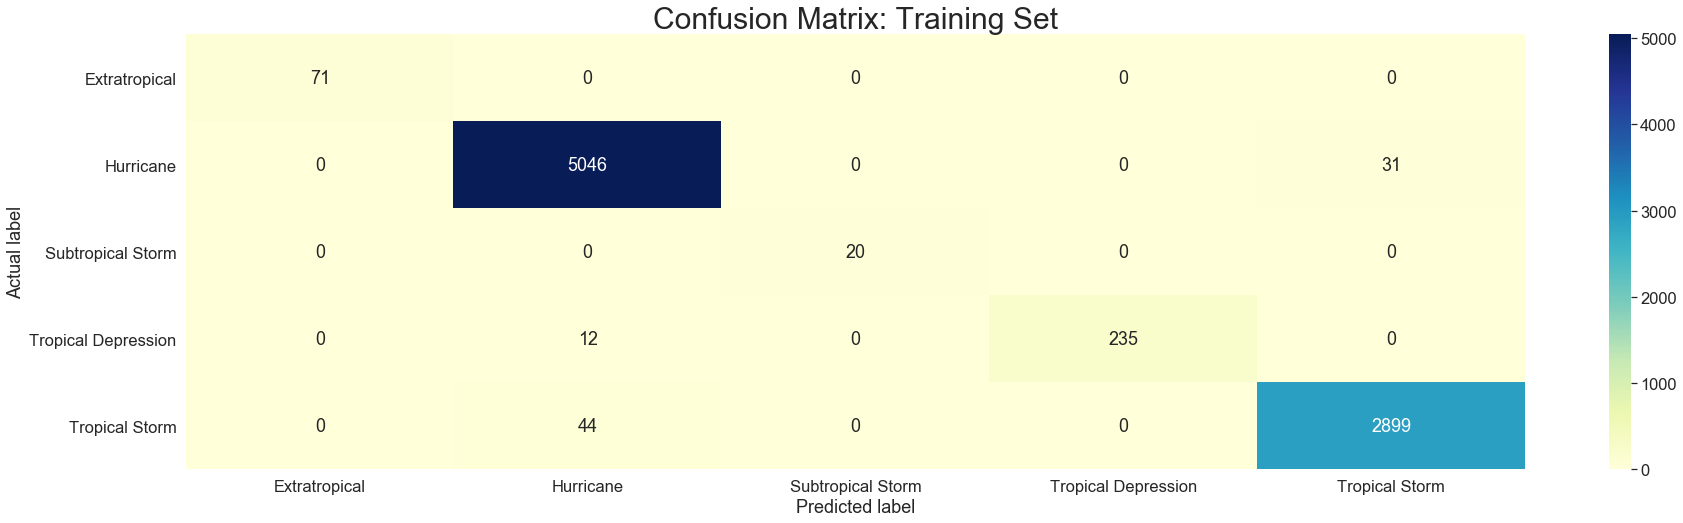

In [96]:
cf_train_matrix = confusion_matrix(y_train, y_train_pred)
class_names=('Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm') # name  of classes
# create heatmap
chart=sb.heatmap(pd.DataFrame(cf_train_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Training Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Training Set

In [97]:
print(classification_report(y_train, y_train_pred))

                     precision    recall  f1-score   support

      Extratropical       1.00      1.00      1.00        71
          Hurricane       0.99      0.99      0.99      5077
  Subtropical Storm       1.00      1.00      1.00        20
Tropical Depression       1.00      0.95      0.98       247
     Tropical Storm       0.99      0.99      0.99      2943

           accuracy                           0.99      8358
          macro avg       1.00      0.99      0.99      8358
       weighted avg       0.99      0.99      0.99      8358



#### Visualization of the first 5 trees of the Random Forest

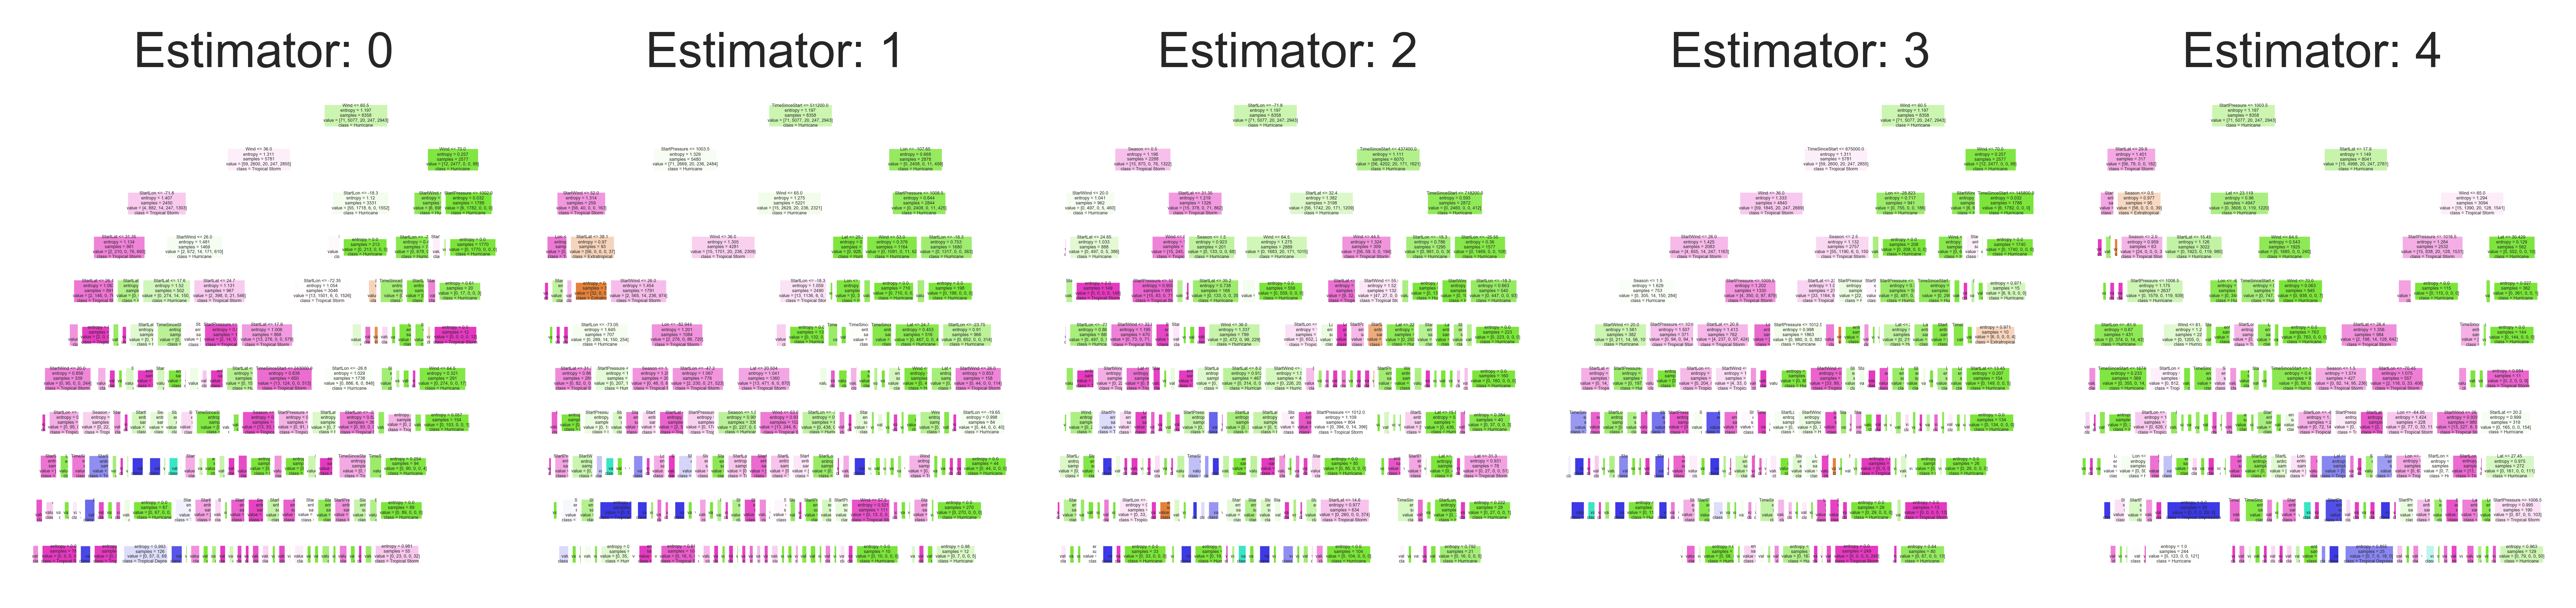

In [98]:
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(RDModel.estimators_[index],
                   feature_names=X_train.columns, 
                   class_names=RDModel.classes_,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

### Cross Validation

In [99]:
y_val_pred = cross_val_predict(RDModel, X_train, y_train, cv = cv_method)

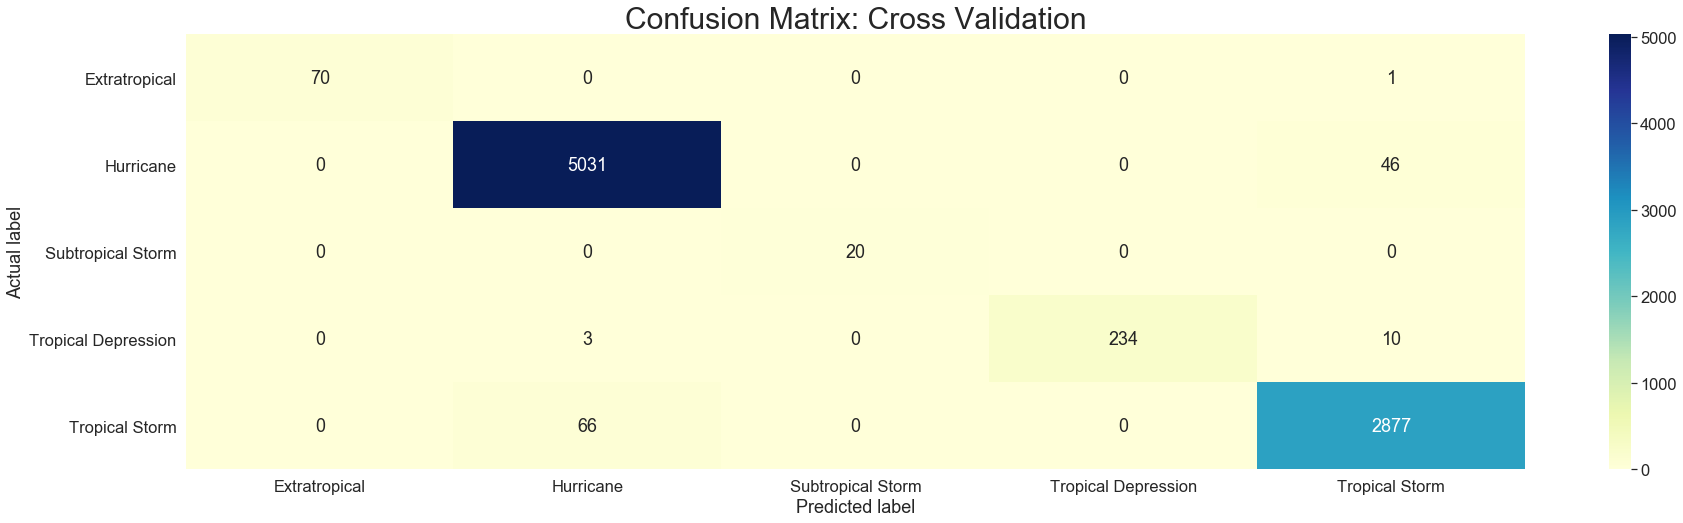

In [100]:
cf_val_matrix = confusion_matrix(y_train, y_val_pred)
chart=sb.heatmap(pd.DataFrame(cf_val_matrix), annot=True, cmap="YlGnBu",fmt='g')
chart.set_title('Confusion Matrix: Cross Validation', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Cross Validation

In [101]:
print(classification_report(y_train, y_val_pred))

                     precision    recall  f1-score   support

      Extratropical       1.00      0.99      0.99        71
          Hurricane       0.99      0.99      0.99      5077
  Subtropical Storm       1.00      1.00      1.00        20
Tropical Depression       1.00      0.95      0.97       247
     Tropical Storm       0.98      0.98      0.98      2943

           accuracy                           0.98      8358
          macro avg       0.99      0.98      0.99      8358
       weighted avg       0.98      0.98      0.98      8358



### Deploying and evaluating the model on the test set

In [102]:
y_pred = RDModel.predict(X_test)

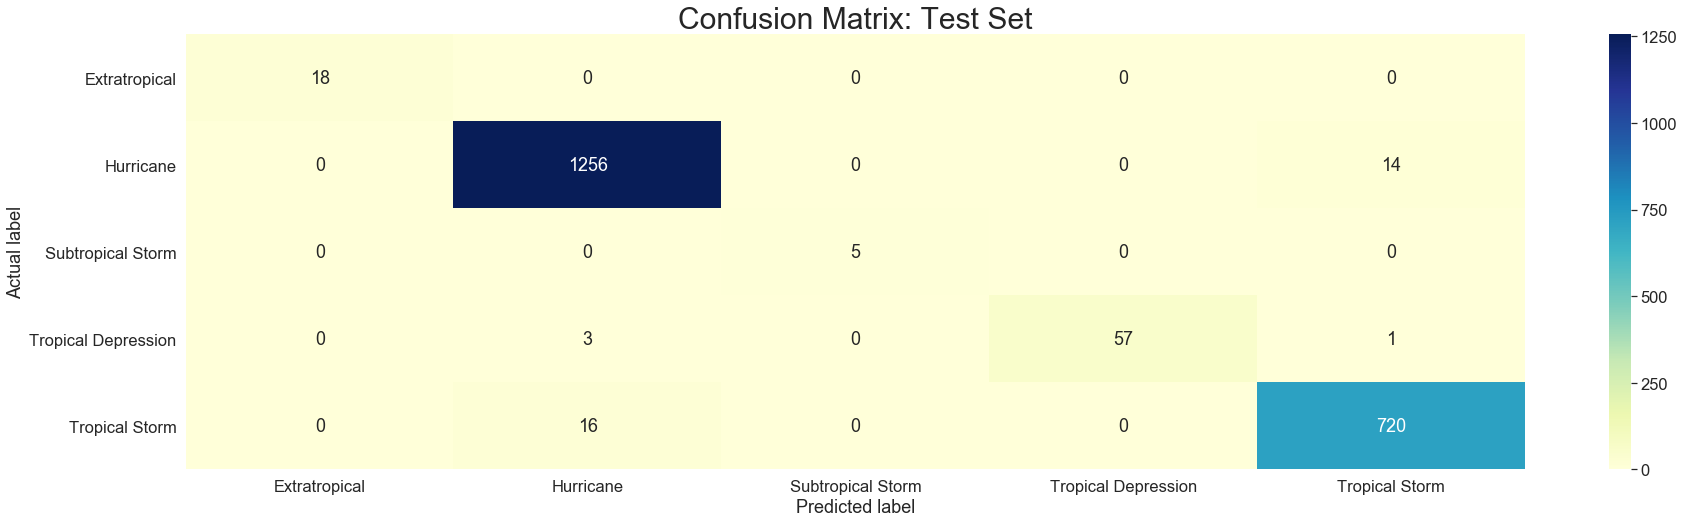

In [103]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
chart=sb.heatmap(pd.DataFrame(cf_test_matrix), annot=True, cmap="YlGnBu", fmt='g')
chart.set_title('Confusion Matrix: Test Set', size=30)
chart.set_ylabel('Actual label')
chart.set_xlabel('Predicted label')
class_names=['Extratropical', 'Hurricane', 'Subtropical Storm', 'Tropical Depression', 'Tropical Storm']
chart.set_xticklabels(class_names, rotation=0)
chart.set_yticklabels(class_names, rotation=0);

#### Classification Report: Test Set

In [104]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      Extratropical       1.00      1.00      1.00        18
          Hurricane       0.99      0.99      0.99      1270
  Subtropical Storm       1.00      1.00      1.00         5
Tropical Depression       1.00      0.93      0.97        61
     Tropical Storm       0.98      0.98      0.98       736

           accuracy                           0.98      2090
          macro avg       0.99      0.98      0.99      2090
       weighted avg       0.98      0.98      0.98      2090



### Discussion of Model 5: Random Forest
Similar to K-Nearest Neighbors and decison tree, Random Forest is a great estimator for this task. Indeed, the training, cross validation, and testing performance metrics for this model are similar and near optimality despite the early pruning. We use the same hyperparameters than in  the decision tree model for comparison and obtained slightly better performance metrics for the Random Forest model.

# 7) Recap

In addition to using stratified split for the training  and test sets split, we have been using stratified folds in all cross validation steps in order to deal with the class imbalance of the target variable.

In sum, logistic regression, and Naive Bayes are poor to average estimators for this task. They also tend to be biased toward the the majority class(es). On the other hand, KNN was a near perfect esmitor for this task and gave a near perfect model at K=1 indicationg a non-linear separation of the classes.

Althought we performed early pruning, the decison tree proved to be a great estimator for this task as well. It also offered insights on the features with the most information gain: Wind, Lat, Lon. The Random Forest proved to be a slightly better model than the decison tree model and was a neear perfect model too.

Because the KNN, decison tree and Random Forest performed extremely well on this dataset, we were wondering if we could get the same near to perfect performance metrics with less features. Hence, we perfomed a dimentionality reduction through PCA to identify the most important features and redo this entire process with dimmentionally reduced models. See the ***Research_Question_C_Part2_Ngone_Lo*** notebook.